#This cell is the old way to set up the conda environment with all the dependencies and mpi4py to run mpi-dask.
#Deprecated
module load python
conda create -c conda-forge -n numeraidask1 \
    python=3 dask distributed ipykernel numpy pandas scikit-learn scipy matplotlib umap-learn scikit-learn-extra

source activate numeraidask1   
pip install umap-learn 

pip install umap
pip install tbb
pip install hdbscan
pip install pynndescent
pip install lhsmdu
pip install git+https://github.com/samueljackson92/coranking.git
pip install shap

wget https://bitbucket.org/mpi4py/mpi4py/downloads/mpi4py-3.0.3.tar.gz
tar zxvf mpi4py-3.0.3.tar.gz
cd mpi4py-3.0.3
module swap PrgEnv-intel PrgEnv-gnu
module unload craype-hugepages2M
python setup.py build --mpicc="$(which cc) -shared"
python setup.py install

conda install -c conda-forge --no-deps dask-mpi


This is the current way to set up the environment.
```
module load python
conda create --name numerai_tf --clone lazy-mpi4py
source activate numerai_tf
conda install dask distributed ipykernel numpy pandas scikit-learn scipy matplotlib

pip install ace
pip install hdbscan
pip install pynndescent
pip install lhsmdu
pip install git+https://github.com/samueljackson92/coranking.git
pip install umap-learn 
pip install umap
pip install scikit-learn-extra
pip install shap
pip install tbb

conda install -c conda-forge --no-deps dask-mpi
python -m ipykernel install --user --name numerai_tf --display-name numerai_tf
```

In [2]:
#Importing depedencies
import pandas as pd
import numpy as np
import datetime
from dask import delayed,compute
from numpy import loadtxt

from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestRegressor
 
from sklearn.cluster import DBSCAN
from sklearn.decomposition import KernelPCA
import hdbscan
from sklearn.ensemble import RandomForestClassifier
import joblib
from joblib import parallel_backend
import itertools
import scipy.stats as st
from sklearn.model_selection import ParameterGrid
from coranking.metrics import trustworthiness as tw
from coranking.metrics import continuity as ct
from coranking.metrics import LCMC as lcmc
import ast
from sklearn.metrics import pairwise_distances_chunked
import dask.array as da
import re
import lhsmdu
from sklearn.neighbors import KNeighborsRegressor
import shap
from sklearn.utils.random import sample_without_replacement

from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples
import scipy.cluster.hierarchy as hac
from scipy.spatial.distance import squareform
import scipy.stats as ss
from sklearn.metrics import mutual_info_score
import copy
import dask
from dask.distributed import wait
from sklearn_extra.cluster import KMedoids
import random
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import PCA
import umap.umap_ as umap
from sklearn.manifold import Isomap
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import MDS
import sys
sys.path.insert(1, 'reduction_dask')

from reduction_dask import tuners
from reduction_dask import metrics
from reduction_dask import utils
from reduction_dask import feature_clustering
from reduction_dask import feature_selection_numerai
import distance_func



# Load the Numerai Dataset as X and Y Dataset

In [3]:
#Read the csv data with Pandas
train_num = pd.read_csv( "../numerai_training_data.csv")
train_num.head(5)

,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,...,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target_kazutsugi
0,n000315175b67977,era1,train,0.00,0.50,0.25,0.00,0.5,0.25,0.25,...,1.00,1.00,0.75,0.50,0.75,0.50,1.00,0.50,0.75,0.75
1,n0014af834a96cdd,era1,train,0.00,0.00,0.00,0.25,0.5,0.00,0.00,...,1.00,1.00,0.00,0.00,0.75,0.25,0.00,0.25,1.00,0.25
2,n001c93979ac41d4,era1,train,0.25,0.50,0.25,0.25,1.0,0.75,0.75,...,0.25,0.50,0.00,0.00,0.50,1.00,0.00,0.25,0.75,0.00
3,n0034e4143f22a13,era1,train,1.00,0.00,0.00,0.50,0.5,0.25,0.25,...,1.00,1.00,0.75,0.75,1.00,1.00,0.75,1.00,1.00,0.00
4,n00679d1a636062f,era1,train,0.25,0.25,0.25,0.25,0.0,0.25,0.50,...,0.75,0.75,0.25,0.50,0.75,0.00,0.50,0.25,0.75,0.75


In [4]:
np.random.seed(42)


In [5]:
#This cleans the data into integer era column and a training data DataFrame
hr_train_num = train_num
hr_train_num['era'] = hr_train_num['era'].map(lambda x: (x.lstrip('era')))
hr_train_num['era'] = hr_train_num['era'].map(lambda x: (int(x)))
num_era = hr_train_num['era']
num_col_names = list(train_num.columns[3:-1])


num_x = hr_train_num.iloc[:, 3:-1]
num_x_nn= pd.concat([num_era, num_x], axis = 1)
num_y = hr_train_num.iloc[:, -1]
num_y_encoded = pd.get_dummies(num_y)
#Sets up the comparison DataFrame for the different dimensionality reduction techniques
redux_race = pd.DataFrame(columns = ['Reduction Technique', 'Spearman Rank Corr by ERA Mean', 'S 25% Quantile','S 75% Quantile','Quartic Mean Error', 'Q 25% Quantile','Q 75% Quantile','Runtime'])
num_x


,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,feature_intelligence8,feature_intelligence9,feature_intelligence10,...,feature_wisdom37,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46
0,0.00,0.50,0.25,0.00,0.50,0.25,0.25,0.25,0.75,0.75,...,1.00,1.00,1.00,0.75,0.50,0.75,0.50,1.00,0.50,0.75
1,0.00,0.00,0.00,0.25,0.50,0.00,0.00,0.25,0.50,0.50,...,0.75,1.00,1.00,0.00,0.00,0.75,0.25,0.00,0.25,1.00
2,0.25,0.50,0.25,0.25,1.00,0.75,0.75,0.25,0.00,0.25,...,0.50,0.25,0.50,0.00,0.00,0.50,1.00,0.00,0.25,0.75
3,1.00,0.00,0.00,0.50,0.50,0.25,0.25,0.75,0.25,0.50,...,0.75,1.00,1.00,0.75,0.75,1.00,1.00,0.75,1.00,1.00
4,0.25,0.25,0.25,0.25,0.00,0.25,0.50,0.25,0.25,0.50,...,0.50,0.75,0.75,0.25,0.50,0.75,0.00,0.50,0.25,0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501803,0.50,0.50,0.25,0.00,0.00,0.50,0.75,0.00,0.75,0.75,...,0.75,0.50,0.50,0.75,0.50,0.50,0.75,0.25,0.25,0.25
501804,1.00,0.00,0.00,1.00,0.50,0.75,0.75,1.00,0.00,0.00,...,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.75,1.00,1.00
501805,0.75,0.50,0.50,0.50,0.25,0.50,0.25,0.50,0.25,0.25,...,1.00,1.00,0.75,0.25,1.00,1.00,1.00,0.25,0.00,0.00
501806,0.25,0.25,0.25,0.50,0.00,1.00,1.00,0.50,0.25,0.25,...,0.50,0.75,0.75,0.75,0.75,0.75,0.50,0.50,0.25,0.75


In [6]:
train_x = num_x.to_numpy()
train_y = num_y
train_era = num_era
# num_cluster_x is used later for feature clustering, to calculate the distance matrix
# as using the whole dataset would take far too long to run
train_era_idx = num_era[num_era==2].index[0]
num_cluster_x = num_x.sample(n =train_era_idx).to_numpy()

A Bash command to start the remote cluster in an HPC environment.
```
cd $SCRATCH
module load python
source activate numeraidask0

export DASK_WORK_STEALING=TRUE
export OMP_NUM_THREADS=1
salloc \
    -N 4 \
    -c 64 \
    -t 4:00:00 \
    -C haswell \
    -q interactive \
    --mem 0 \
    srun -u python -u \
        $(which dask-mpi) \
            --scheduler-file=scheduler.json \
            --dashboard-address=0 \
            --memory-limit=0 \
            --no-nanny \
            --local-directory=/tmp 
```  

In [7]:
#import Dask Dependencies
import os

import dask
from dask.distributed import Client
from dask.diagnostics import ProgressBar 
from dask.distributed import progress
import dask.array as da


import time
os.environ["OMP_NUM_THREADS"] = "1"
scheduler_file = os.path.join(os.environ["SCRATCH"], "scheduler.json")
dask.config.config["distributed"]["dashboard"]["link"] = "{JUPYTERHUB_SERVICE_PREFIX}proxy/{host}:{port}/status"

In [8]:
!export DASK_WORK_STEALING= True


In [12]:
#Intialize Dask cluster as Client. All cluster jobs submitted through this object.
client = Client(threads_per_worker=64, scheduler_file=scheduler_file)


client.restart()
client.upload_file('reduction_dask/metrics.py')

client.upload_file('reduction_dask/utils.py')
client.upload_file('reduction_dask/tuners.py')

client.upload_file('reduction_dask/feature_selection_numerai.py')
client.upload_file('distance_func.py')
client.upload_file('reduction_dask/feature_clustering.py')

client


Client Scheduler: tcp://10.128.0.96:46021 Dashboard: /user/jc738/cori-exclusive-node-cpu/proxy/10.128.0.96:39063/status,Cluster Workers: 19 Cores: 1216 Memory: 0 B


## Basic Data EDA 

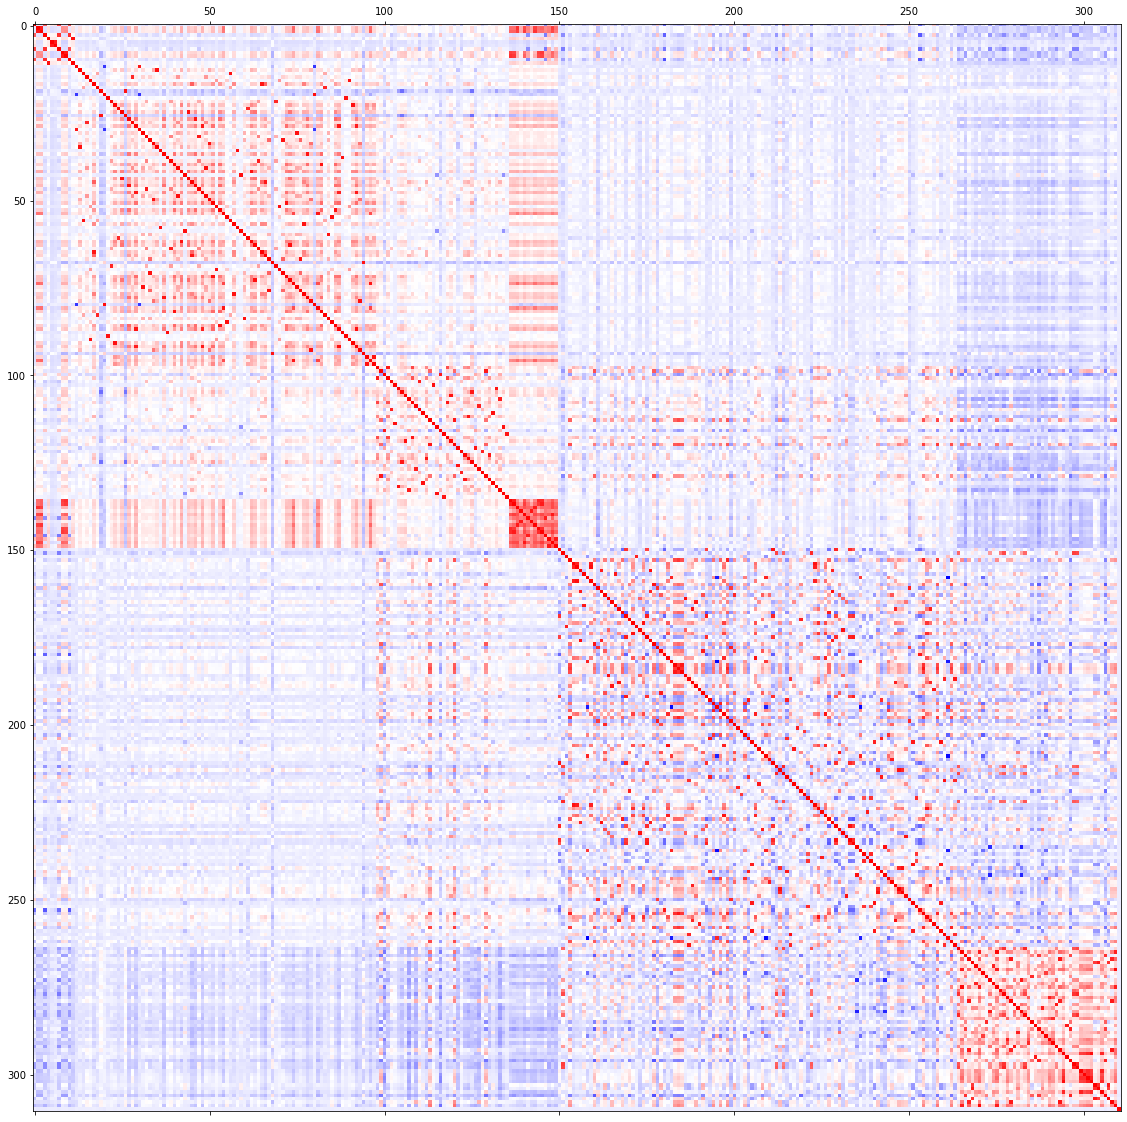

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))
ax.matshow(hr_train_num.iloc[:, 3:].corr(), cmap='bwr')
plt.savefig('../NumeraiCorr')

In [ ]:
u, s, vh = np.linalg.svd(num_train_x[:31240])
s

NameError: name 'num_train_x' is not defined

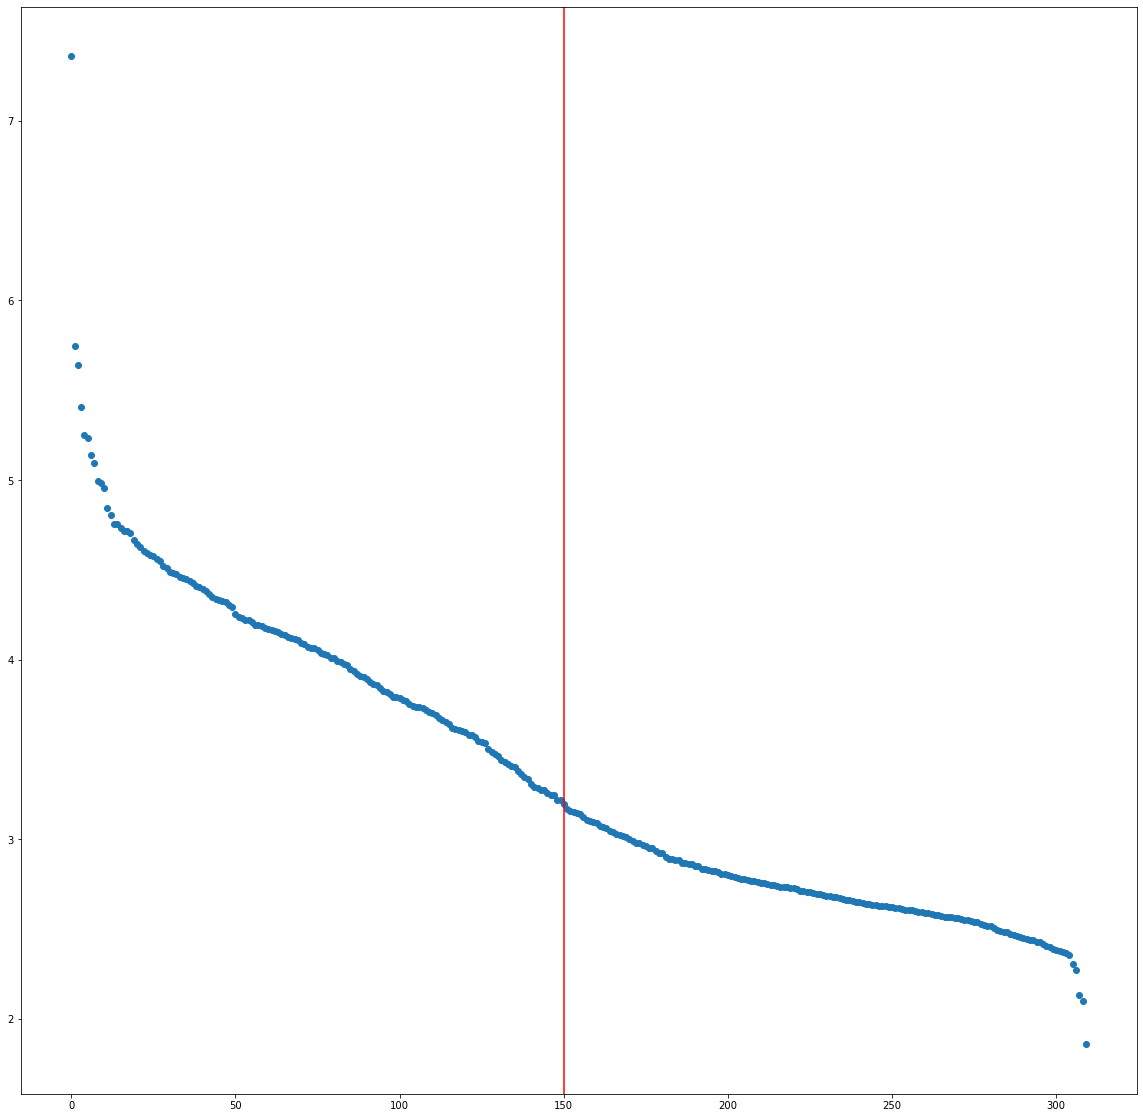

In [ ]:
plt.figure(figsize=(20,20))
plt.scatter(y = np.log(s),x = range(310))
plt.axvline(150, color  = 'r')

# Random Forest | Benchmark

## Model Tuning

In [48]:
#There are two options to hyperparameter tuning. One option is to use Latin Hypercube Sampling, effectively a more efficient Random Sampling search. The other is
#Hyperband, which trains promising configurations with more data and discards ones which seem less promising with less data.

#Latin Hypercube Sampling
params = [{
    
    "n_estimators": range(500,1501,250),
    "min_samples_split" : range(2,10, 2),
    "max_leaf_nodes" : range(400,751,20),
    #"oob_score" :[True],
    "max_depth": range(3,55,10),
    "min_samples_leaf":range(5,40,2),
    "max_samples": np.arange(5,10)*.1,
    "verbose" : [0], 
    "n_jobs" : [-1],
    "random_state" : [42],
    "max_features" : ['log2'],
    "criterion" : ['mse']
}]
model = RandomForestRegressor
hyp_param = tuners.tune_dask_kfold(model,train_x, train_y,train_era, 6,params, 1000,client,workers)

In [ ]:
#Hyperband
params = [{
    
    "n_estimators": range(250,500,250),
    "min_samples_split" : range(2,10, 2),
    "max_leaf_nodes" : range(400,751,20),
    #"oob_score" :[True],
    "max_depth": range(3,55,10),
    "min_samples_leaf":range(5,40,2),
    "max_samples": np.arange(5,10)*.1,
    "verbose" : [0], 
    "n_jobs" : [-1],
    "random_state" : [42],
    "max_features" : range(5,100,5),
    "criterion" : ['mse']
}]
model = RandomForestRegressor
hyp_param = tuners.hyperband(model,train_x, train_y,train_era, 6,params, 500,3,100,client)

Done Scattering

*** 81 configurations x 1.2 ratio
0 0 486
0
8 0 478
5
61 0 425
10
85 12 389
15
129 22 335
20
169 22 295
25
203 78 205
30
258 126 102
35
296 135 55
40


In [11]:
hyp_param

(0.04373731959329621,
 {'criterion': 'mse',
  'max_depth': 23,
  'max_features': 55,
  'max_leaf_nodes': 400,
  'max_samples': 0.9,
  'min_samples_leaf': 39,
  'min_samples_split': 4,
  'n_estimators': 250,
  'n_jobs': -1,
  'random_state': 42,
  'verbose': 0})

## Evaluation 

In [12]:


model =RandomForestRegressor(criterion= 'mse',
                               random_state = 42,
                               n_estimators =1000,
                               max_depth=53,
                               verbose = 0,
                               max_features= 70, 
                               n_jobs=-1,
                               max_leaf_nodes=400, 
                               min_samples_leaf = 39, 
                               min_samples_split = 8,
                               max_samples = .7)
spearman, qme = tuners.kfold_dask(model,train_x, train_y, train_era,12,client)
redux_race = pd.DataFrame({"Reduction Technique": "None", 'Spearman Rank Corr by ERA Mean':spearman[0],'S 25% Quantile': spearman[1][0],'S 75% Quantile':spearman[1][1],'Quartic Mean Error': qme[0],'Q 25% Quantile': qme[1][0],'Q 75% Quantile':qme[1][1],'Runtime':'None'},index=[0])
redux_race.to_csv('../numerai_reduction_race.csv',mode='a')

0 0 12
0
0 0 12
5
0 0 12
10
0 0 12
15
0 0 12
20
0 0 12
25
0 0 12
30
0 0 12
35
0 0 12
40
0 0 12
45
0 0 12
50
0 0 12
55
0 0 12
60
0 0 12
65
0 0 12
70
0 0 12
75
0 0 12
80
0 0 12
85
0 0 12
90
0 0 12
95
0 0 12
100
0 0 12
105
0 0 12
110
0 0 12
115
0 0 12
120
0 0 12
125
0 0 12
130
0 0 12
135
0 0 12
140
0 0 12
145
0 0 12
150
0 0 12
155
0 0 12
160
0 0 12
165
0 0 12
170
0 0 12
175
0 0 12
180
0 0 12
185
0 0 12
190
0 0 12
195
1 0 11
200
3 0 9
205
5 0 7
210
6 0 6
215
7 0 5
220
7 0 5
225
9 0 3
230
11 0 1
235
11 0 1
240
12 0 0


In [13]:
redux_race

,Reduction Technique,Spearman Rank Corr by ERA Mean,S 25% Quantile,S 75% Quantile,Quartic Mean Error,Q 25% Quantile,Q 75% Quantile,Runtime
0,None,0.047209,0.03824,0.0566,0.026411,0.026363,0.026437,None


# SHAP Values | Feature Selection


In [12]:
# Initialize JavaSCript Plugin for SHAP visualizations
shap.initjs()

In [13]:
# Calcualate SHAP values using same model used to tune each DR algorithm
model =RandomForestRegressor(criterion= 'mse',
                              max_depth= 23,
                              max_features= 55,
                              max_leaf_nodes= 400,
                              max_samples= 0.9,
                              min_samples_leaf= 39,
                              min_samples_split= 4,
                              n_estimators= 250,
                              n_jobs= -1,
                              random_state=42,
                              verbose= 0)

start_time = time.time()
shap_values = feature_selection_numerai.shapely_values(model,train_x,train_y)
runtime = time.time()-start_time

shap_values

100%|===================| 995/1000 [00:42<00:00]        

,Feature,Score
142,142,0.002069
141,141,0.001656
139,139,0.001065
146,146,0.000907
74,74,0.000861
...,...,...
76,76,0.000013
135,135,0.000011
58,58,0.000010
117,117,0.000009


In [48]:
# Save SHAP values since they are expensive to compute
shap_val.sort_values('Score', ascending = False, inplace = True)
shap_val.to_csv('../Precomputed SHAP Values/SHAP_Benchmark')


,Feature,Score
142,142,0.001722
141,141,0.001273
139,139,0.001208
146,146,0.000934
149,149,0.000839
...,...,...
84,84,0.000013
58,58,0.000009
135,135,0.000008
117,117,0.000008


In [53]:
shap_val = pd.read_csv('../Precomputed SHAP Values/SHAP_Benchmark')
shap_val.drop('Unnamed: 0', axis=1, inplace=True)
shap_val

,Feature,Score
0,142,0.001722
1,141,0.001273
2,139,0.001208
3,146,0.000934
4,149,0.000839
...,...,...
305,84,0.000013
306,58,0.000009
307,135,0.000008
308,117,0.000008


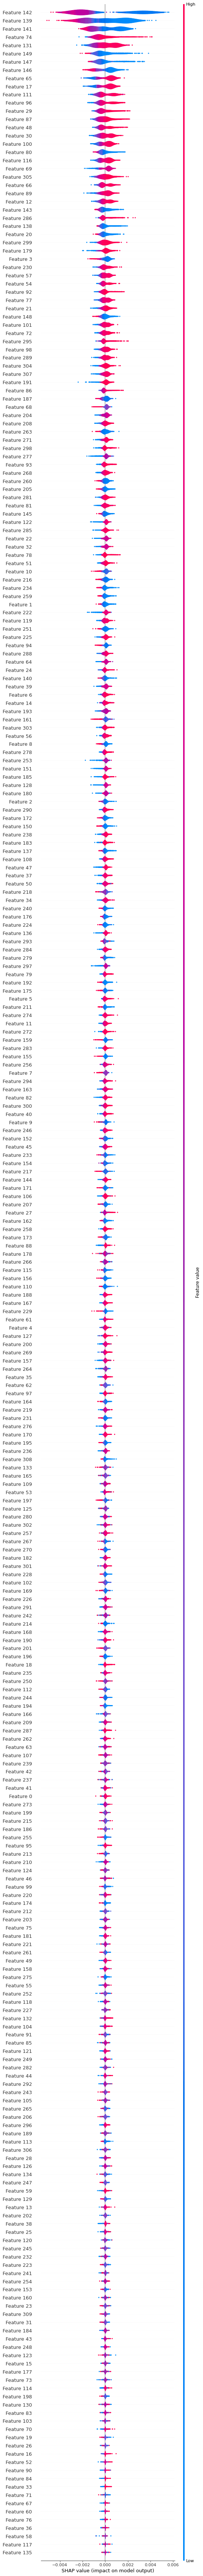

NameError: name 'violin_plot' is not defined

In [49]:
# Visualize the SHAP values for each feature
fig = plt.figure()

violnum_col_names= shap.summary_plot(shap_values, num_train_x[:1000], max_display = inplace=plot_type ='violin')
fig.savefig("violin_benchmark.png", bbox_inches='tight', dpi=200)
violin_plot

In [ ]:
fig = plt.figure()

shap.summary_plot(shap_values,num_train_x[:1000], plot_type="bar", max_display = 310)
fig.savefig("mean_SHAP_benchmark.png", bbox_inches='tight', dpi=200)


## DR Tuning

In [14]:
# The number of features selected is chosen by using the wrapper method of feature selection. The model is given top N features by SHAP value 
model =RandomForestRegressor(criterion= 'mse',
                              max_depth= 23,
                              max_features= 'auto',
                              max_leaf_nodes= 400,
                              max_samples= 0.9,
                              min_samples_leaf= 39,
                              min_samples_split= 4,
                              n_estimators= 250,
                              n_jobs= -1,
                              random_state=42,
                              verbose= 0)
shap_tune = feature_selection_numerai.shap_tune(model,train_x,train_y,train_era, shap_values, 6,192,client)
shap_tune

0 0 1146
0
0 0 1146
5
0 0 1146
10
0 0 1146
15
0 0 1146
20
0 0 1146
25
0 0 1146
30
0 0 1146
35
0 0 1146
40
0 0 1146
45
0 0 1146
50
0 0 1146
55
0 0 1146
60
0 0 1146
65
0 0 1146
70
0 0 1146
75
0 0 1146
80
0 0 1146
85
0 0 1146
90
0 0 1146
95
0 0 1146
100
1 0 1145
105
1 0 1145
110
1 0 1145
115
2 0 1144
120
3 0 1143
125
4 0 1142
130
5 0 1141
135
10 0 1136
140
14 0 1132
145
16 0 1130
150
19 0 1127
155
24 0 1122
160
30 0 1116
165
36 0 1110
170
38 0 1108
175
41 0 1105
180
45 0 1101
185
53 0 1093
190
56 0 1090
195
66 0 1080
200
70 0 1076
205
74 0 1072
210
76 0 1070
215
78 0 1068
220
83 0 1063
225
83 0 1063
230
86 0 1060
235
86 0 1060
240
87 0 1059
245
91 0 1055
250
94 0 1052
255
98 0 1048
260
101 0 1045
265
102 0 1044
270
103 0 1043
275
103 0 1043
280
105 0 1041
285
106 0 1040
290
110 0 1036
295
112 0 1034
300
113 0 1033
305
115 0 1031
310
117 0 1029
315
120 0 1026
320
121 0 1025
325
123 0 1023
330
126 0 1020
335
131 0 1015
340
136 0 1010
345
136 0 1010
350
139 0 1007
355
141 0 1005
360
141 0 10

,Number of Clusters,Spearman Rank Correlation,Quartic Mean Error
143,144,0.047493,0.026421
144,145,0.047396,0.026421
142,143,0.047285,0.026422
124,125,0.047208,0.026422
146,147,0.047198,0.026422
...,...,...,...
4,5,0.019556,0.026577
1,2,0.016480,0.026484
0,1,0.015588,0.026478
2,3,0.015552,0.026499


In [15]:
# This transforms our X dataset using the optimal hyperparameters given by the cell above.

SHAP_train_x = feature_selection_numerai.shap_selector(train_x, shap_values, 144)
SHAP_train_x

array([[1.  , 0.75, 1.  , ..., 0.5 , 0.75, 0.5 ],
       [0.25, 0.25, 0.5 , ..., 0.75, 0.5 , 0.75],
       [1.  , 0.25, 1.  , ..., 0.25, 0.25, 0.25],
       ...,
       [0.5 , 0.25, 0.5 , ..., 0.75, 0.5 , 1.  ],
       [1.  , 0.5 , 1.  , ..., 0.25, 0.25, 0.25],
       [0.75, 0.25, 0.75, ..., 0.25, 0.25, 0.25]])

## Model Tuning

In [13]:
params = [{
    
    "n_estimators": range(500,1501,250),
    "min_samples_split" : range(2,10, 2),
    "max_leaf_nodes" : range(400,751,20),
    #"oob_score" :[True],
    "max_depth": range(3,55,10),
    "min_samples_leaf":range(5,40,2),
    "max_samples": np.arange(5,10)*.1,
    "verbose" : [0], 
    "n_jobs" : [-1],
    "random_state" : [42],
    "max_features" : range(5,50,5),
    "criterion" : ['mse']
}]
model = RandomForestRegressor
hyp_param = tuners.hyperband(model,train_x,train_y,train_era, 6,params, 500,3,100,client)

Done Scattering

*** 81 configurations x 1.2 ratio
0 0 486
0
0 0 486
5
30 0 456
10
72 0 414
15
142 0 344
20
371 0 115
25
486 0 0

0 | current score: 0.021766466569622434 | best score so far: 0.0218 (parameters {'criterion': 'mse', 'max_depth': 3, 'max_features': 35, 'max_leaf_nodes': 620, 'max_samples': 0.6000000000000001, 'min_samples_leaf': 27, 'min_samples_split': 4, 'n_estimators': 1500, 'n_jobs': -1, 'random_state': 42, 'verbose': 0})


*** 27.0 configurations x 3.7 ratio
0 0 162
0
16 0 146
5
139 0 23
10
162 0 0

0 | current score: 0.030568825493597046 | best score so far: 0.0306 (parameters {'criterion': 'mse', 'max_depth': 3, 'max_features': 45, 'max_leaf_nodes': 440, 'max_samples': 0.6000000000000001, 'min_samples_leaf': 27, 'min_samples_split': 6, 'n_estimators': 1500, 'n_jobs': -1, 'random_state': 42, 'verbose': 0})


*** 9.0 configurations x 11.1 ratio
0 0 54
0
18 0 36
5
54 0 0

0 | current score: 0.03325422226679224 | best score so far: 0.0333 (parameters {'criterion': 'mse

In [14]:
hyp_param

(0.04545762327038765,
 {'criterion': 'mse',
  'max_depth': 13,
  'max_features': 35,
  'max_leaf_nodes': 520,
  'max_samples': 0.6000000000000001,
  'min_samples_leaf': 31,
  'min_samples_split': 2,
  'n_estimators': 1500,
  'n_jobs': -1,
  'random_state': 42,
  'verbose': 0})

## Evaluation

In [16]:

model =RandomForestRegressor(criterion= 'mse',
                               random_state = 42,
                               n_estimators =1500,
                               max_depth=13,
                               verbose = 0,
                               max_features= 35, 
                               n_jobs=-1,
                               max_leaf_nodes=520, 
                               min_samples_leaf = 31, 
                               min_samples_split = 2,
                               max_samples = .6)
spearman, qme = tuners.kfold_dask(model,SHAP_train_x, train_y, train_era,12,client)
redux_race = pd.DataFrame({"Reduction Technique": "SHAP - 143", 'Spearman Rank Corr by ERA Mean':spearman[0],'S 25% Quantile': spearman[1][0],'S 75% Quantile':spearman[1][1],'Quartic Mean Error': qme[0],'Q 25% Quantile': qme[1][0],'Q 75% Quantile':qme[1][1],'Runtime':'None'},index=[0])
redux_race.to_csv('../numerai_reduction_race.csv',mode='a')

0 0 12
0
0 0 12
5
0 0 12
10
0 0 12
15
0 0 12
20
0 0 12
25
0 0 12
30
0 0 12
35
0 0 12
40
0 0 12
45
0 0 12
50
0 0 12
55
0 0 12
60
0 0 12
65
0 0 12
70
0 0 12
75
0 0 12
80
0 0 12
85
0 0 12
90
0 0 12
95
0 0 12
100
0 0 12
105
0 0 12
110
0 0 12
115
0 0 12
120
0 0 12
125
0 0 12
130
0 0 12
135
0 0 12
140
2 0 10
145
4 0 8
150
6 0 6
155
9 0 3
160
12 0 0


In [17]:
redux_race

,Reduction Technique,Spearman Rank Corr by ERA Mean,S 25% Quantile,S 75% Quantile,Quartic Mean Error,Q 25% Quantile,Q 75% Quantile,Runtime
0,SHAP - 143,0.049074,0.045079,0.053384,0.026408,0.026384,0.026426,None


# MDA | Feature Selection

In [16]:
# Note this is the same model used for SHAP values and tuning
model =RandomForestRegressor(criterion= 'mse',
                               random_state = 42,
                               n_estimators =1000,
                               max_depth=53,
                               verbose = 0,
                               max_features= 70, 
                               n_jobs=-1,
                               max_leaf_nodes=400, 
                               min_samples_leaf = 39, 
                               min_samples_split = 8,
                               max_samples = .7)

In [17]:
start_time = time.time()
MDA_values= feature_selection_numerai.mean_decrease_accuracy(model,train_x,train_y,train_era, 6,client)
runtime = time.time()-start_time
MDA_values

0 0 6
0
0 0 6
5
0 0 6
10
0 0 6
15
0 0 6
20
0 0 6
25
0 0 6
30
0 0 6
35
0 0 6
40
0 0 6
45
0 0 6
50
0 0 6
55
0 0 6
60
0 0 6
65
0 0 6
70
0 0 6
75
0 0 6
80
0 0 6
85
0 0 6
90
0 0 6
95
0 0 6
100
0 0 6
105
0 0 6
110
0 0 6
115
0 0 6
120
0 0 6
125
0 0 6
130
0 0 6
135
0 0 6
140
0 0 6
145
0 0 6
150
0 0 6
155
0 0 6
160
0 0 6
165
0 0 6
170
0 0 6
175
0 0 6
180
0 0 6
185
0 0 6
190
0 0 6
195
0 0 6
200
0 0 6
205
0 0 6
210
1 0 5
215
5 0 1
220
6 0 0


Large object of size 51.39 MB detected in task graph: 
  (RandomForestRegressor(max_depth=53, max_features= ... 8d29fa707956a')
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
Task exception was never retrieved
future: <Task finished coro=<connect.<locals>._() done, defined at /global/homes/j/jc738/.conda/envs/numeraidask0/lib/python3.7/site-packages/distributed/comm/core.py:288> exception=CommClosedError()>
Traceback (most recent call last):
  File "/global/homes/j/jc738/.conda/envs/numeraidask0/lib/python3.7/site-packages/distributed/comm/core.py", line 297, in _
    handshake = await asyncio.wait_for(comm.read(), 1)
  File "/global/homes/j/jc738/.conda/envs/numeraidask0/lib/python3.7/asyncio/tasks.py", line 448, in wait_for
    await _cancel_and_wait(fut

Features sorted by their score:


,Score,Feature
0,0.002566,[142]
1,0.001696,[141]
2,0.001008,[146]
3,0.000929,[139]
4,0.000783,[149]
...,...,...
305,-0.000163,[78]
306,-0.000172,[27]
307,-0.000174,[182]
308,-0.000181,[40]


In [17]:
# Save MDA values since they are expensive to compute
MDA_values.to_csv("../MDA_Untransformed.csv")

In [18]:
MDA_values = pd.read_csv("../MDA_Untransformed.csv").iloc[:,1:]
MDA_values

,Score,Feature
0,0.001823,[142]
1,0.001143,[139]
2,0.001116,[141]
3,0.001020,[74]
4,0.000964,[149]
...,...,...
305,-0.000115,[92]
306,-0.000123,[63]
307,-0.000134,[51]
308,-0.000151,[179]


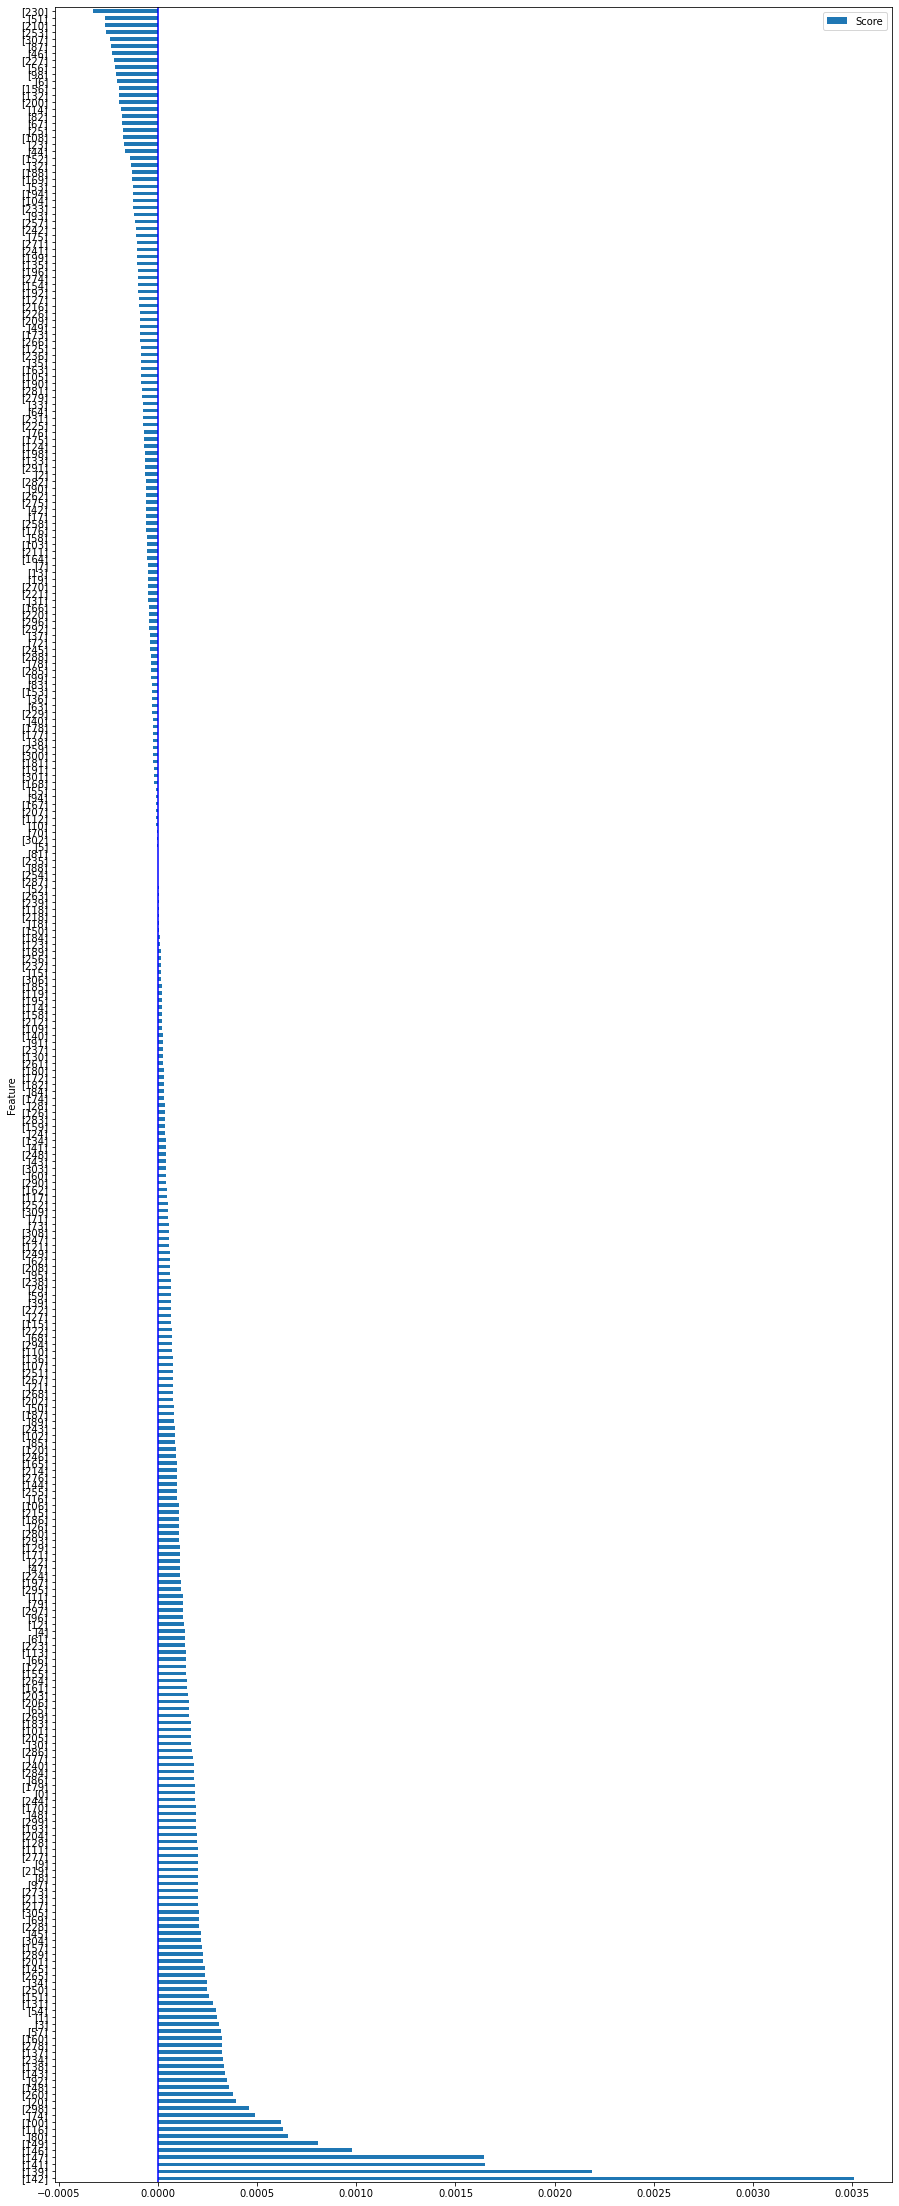

In [29]:
# Visualize the MDA values for each feature
feat_score.plot.barh(x = 'Feature', y = 'Score', figsize=(15,40))

plt.axvline(x= 0, color = 'b')
plt.savefig('MDA_Normal_Barh')

## DR Tuning

In [24]:

model =RandomForestRegressor(criterion= 'mse',
                               random_state = 42,
                               n_estimators =1000,
                               max_depth=53,
                               verbose = 0,
                               max_features= 'auto', 
                               n_jobs=-1,
                               max_leaf_nodes=400, 
                               min_samples_leaf = 39, 
                               min_samples_split = 8,
                               max_samples = .7)

MDA_tune = feature_selection_numerai.mean_decrease_accuracy_tune(model,train_x,train_y,train_era, MDA_values,6,150 ,client)
MDA_tune

0 0 894
0
0 0 894
5
0 0 894
10
0 0 894
15
0 0 894
20
0 0 894
25
0 0 894
30
0 0 894
35
0 0 894
40
0 0 894
45
0 0 894
50
0 0 894
55
0 0 894
60
0 0 894
65
0 0 894
70
0 0 894
75
0 0 894
80
0 0 894
85
0 0 894
90
0 0 894
95
0 0 894
100
0 0 894
105
0 0 894
110
0 0 894
115
0 0 894
120
0 0 894
125
0 0 894
130
0 0 894
135
0 0 894
140
0 0 894
145
0 0 894
150
0 0 894
155
0 0 894
160
0 0 894
165
0 0 894
170
0 0 894
175
2 0 892
180
2 0 892
185
3 0 891
190
4 0 890
195
4 0 890
200
4 0 890
205
4 0 890
210
5 0 889
215
5 0 889
220
5 0 889
225
7 0 887
230
7 0 887
235
8 0 886
240
8 0 886
245
8 0 886
250
8 0 886
255
9 0 885
260
9 0 885
265
11 0 883
270
12 0 882
275
12 0 882
280
15 0 879
285
15 0 879
290
17 0 877
295
17 0 877
300
17 0 877
305
18 0 876
310
18 0 876
315
19 0 875
320
21 0 873
325
21 0 873
330
21 0 873
335
21 0 873
340
22 0 872
345
22 0 872
350
22 0 872
355
23 0 871
360
23 0 871
365
25 0 869
370
26 0 868
375
28 0 866
380
29 0 865
385
30 0 864
390
30 0 864
395
31 0 863
400
31 0 863
405
33 0 861
4

,Number of Clusters,Spearman Rank Correlation,Quartic Mean Error
70,71,0.048687,0.026419
71,72,0.048611,0.026419
101,102,0.048586,0.026418
72,73,0.048527,0.026419
76,77,0.048502,0.026418
...,...,...,...
4,5,0.022465,0.026584
3,4,0.020482,0.026547
1,2,0.016281,0.026488
2,3,0.014994,0.026503


distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
ERROR:asyncio:_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError


In [18]:
# This transforms our X dataset using the optimal hyperparameters given by the cell above.

MDA_train_x = feature_selection_numerai.mean_decrease_accuracy_selector(train_x,MDA_values,71)

## Model Tuning

In [20]:
params = [{
    
    "n_estimators": range(500,1501,250),
    "min_samples_split" : range(2,10, 2),
    "max_leaf_nodes" : range(400,751,20),
    #"oob_score" :[True],
    "max_depth": range(3,55,10),
    "min_samples_leaf":range(5,40,2),
    "max_samples": np.arange(5,10)*.1,
    "verbose" : [0], 
    "n_jobs" : [-1],
    "random_state" : [42],
    "max_features" : range(5,50,5),
    "criterion" : ['mse']
}]
model = RandomForestRegressor
hyp_param = tuners.hyperband(model,MDA_train_x,train_y,train_era, 6,params, 500,3,100,client)

Done Scattering

*** 81 configurations x 1.2 ratio
0 0 486
0
3 0 483
5
30 0 456
10
115 0 371
15
372 0 114
20
486 0 0

0 | current score: 0.02080688017177525 | best score so far: 0.0208 (parameters {'criterion': 'mse', 'max_depth': 3, 'max_features': 40, 'max_leaf_nodes': 600, 'max_samples': 0.5, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 1500, 'n_jobs': -1, 'random_state': 42, 'verbose': 0})


*** 27.0 configurations x 3.7 ratio
0 0 162
0
15 0 147
5
135 0 27
10
162 0 0

0 | current score: 0.034892500803111993 | best score so far: 0.0349 (parameters {'criterion': 'mse', 'max_depth': 33, 'max_features': 10, 'max_leaf_nodes': 740, 'max_samples': 0.8, 'min_samples_leaf': 31, 'min_samples_split': 6, 'n_estimators': 1500, 'n_jobs': -1, 'random_state': 42, 'verbose': 0})


*** 9.0 configurations x 11.1 ratio
0 0 54
0
51 0 3
5
54 0 0

0 | current score: 0.04025764074622836 | best score so far: 0.0403 (parameters {'criterion': 'mse', 'max_depth': 33, 'max_features': 10, 'max

In [23]:
hyp_param

(0.051254670230930555,
 {'criterion': 'mse',
  'max_depth': 23,
  'max_features': 25,
  'max_leaf_nodes': 420,
  'max_samples': 0.7000000000000001,
  'min_samples_leaf': 33,
  'min_samples_split': 6,
  'n_estimators': 1500,
  'n_jobs': -1,
  'random_state': 42,
  'verbose': 0})

## Evaluation 

In [19]:
model = RandomForestRegressor(criterion= 'mse',
                              max_depth= 23,
                              max_features= 25,
                              max_leaf_nodes= 420,
                              max_samples= 0.7,
                              min_samples_leaf= 33,
                              min_samples_split= 6,
                              n_estimators= 1500,
                              n_jobs= -1,
                              random_state= 42,
                              verbose = 0)

In [20]:
spearman, qme = tuners.kfold_dask(model,MDA_train_x, train_y, train_era,12,client)
redux_race = pd.DataFrame({"Reduction Technique": "MDA - 71", 'Spearman Rank Corr by ERA Mean':spearman[0],'S 25% Quantile': spearman[1][0],'S 75% Quantile':spearman[1][1],'Quartic Mean Error': qme[0],'Q 25% Quantile': qme[1][0],'Q 75% Quantile':qme[1][1],'Runtime':runtime},index=[0])
redux_race.to_csv('../numerai_reduction_race.csv',mode='a',header=False)

0 0 12
0
0 0 12
5
0 0 12
10
0 0 12
15
0 0 12
20
0 0 12
25
0 0 12
30
0 0 12
35
0 0 12
40
0 0 12
45
0 0 12
50
0 0 12
55
0 0 12
60
0 0 12
65
0 0 12
70
0 0 12
75
0 0 12
80
0 0 12
85
0 0 12
90
0 0 12
95
0 0 12
100
0 0 12
105
0 0 12
110
1 0 11
115
6 0 6
120
11 0 1
125
12 0 0


In [21]:
redux_race

,Reduction Technique,Spearman Rank Corr by ERA Mean,S 25% Quantile,S 75% Quantile,Quartic Mean Error,Q 25% Quantile,Q 75% Quantile,Runtime
0,MDA - 71,0.049398,0.043473,0.055674,0.026405,0.026384,0.026427,1706.725343


# Isomap | Feature Extraction

## DR Tuning

In [11]:
# Same model as the other 2 above.
model =RandomForestRegressor(criterion= 'mse',
                              max_depth= 23,
                              max_features= 'auto',
                              max_leaf_nodes= 400,
                              max_samples= 0.9,
                              min_samples_leaf= 39,
                              min_samples_split= 4,
                              n_estimators= 250,
                              n_jobs= -1,
                              random_state=42,
                              verbose= 0)

In [16]:
# Unlike Feature selection methods, we hyperparameter tune using modified Hyperband for these techniques. 
params = [{
    "n_neighbors":range(5,50,5),
    "n_components": range(3,150,10),
    "n_jobs": [-1],
    "metric": ["minkowski", "cosine", "correlation","l1"]
}]

isomap = Isomap
isomap_tune = tuners.tune_reduction_hyperband(isomap,model, train_x,train_y, train_era, 6,params,500,3,100,9746,4,client,memory_limit=50,low_memory=True)


Done Scattering

*** 43.0 configurations x 2.3 ratio


Large object of size 92.33 MB detected in task graph: 
  (RandomForestRegressor(max_depth=23, max_leaf_node ... 75bbeee1199cc')
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good


8 0 250
0
8 0 250
5
9 0 249
10
10 0 248
15
12 0 246
20
14 0 244
25
15 0 243
30
16 0 242
35
18 0 240
40
23 0 235
45
24 0 234
50
27 0 231
55
29 0 229
60
32 0 226
65
35 0 223
70
36 0 222
75
36 0 222
80
36 0 222
85
36 0 222
90
36 0 222
95
36 0 222
100
36 0 222
105
36 0 222
110
36 0 222
115
36 0 222
120
36 0 222
125
36 0 222
130
36 0 222
135
36 0 222
140
36 0 222
145
37 0 221
150
38 0 220
155
38 0 220
160
38 0 220
165
38 0 220
170
39 0 219
175
39 0 219
180
39 0 219
185
39 0 219
190
40 0 218
195
41 0 217
200
42 0 216
205
42 0 216
210
42 0 216
215
42 0 216
220
42 0 216
225
42 0 216
230
42 0 216
235
42 0 216
240
42 0 216
245
42 0 216
250
42 0 216
255
42 0 216
260
42 0 216
265
42 0 216
270
42 0 216
275
42 0 216
280
42 0 216
285
42 0 216
290
42 0 216
295
42 0 216
300
42 0 216
305
42 0 216
310
42 0 216
315
42 0 216
320
42 0 216
325
42 0 216
330
44 0 214
335
44 0 214
340
45 0 213
345
45 0 213
350
45 0 213
355
46 0 212
360
47 0 211
365
48 0 210
370
49 0 209
375
50 0 208
380
51 0 207
385
51 0 207
39

Task exception was never retrieved
future: <Task finished coro=<connect.<locals>._() done, defined at /global/homes/j/jc738/.conda/envs/numeraidask0/lib/python3.7/site-packages/distributed/comm/core.py:288> exception=CommClosedError()>
Traceback (most recent call last):
  File "/global/homes/j/jc738/.conda/envs/numeraidask0/lib/python3.7/site-packages/distributed/comm/core.py", line 297, in _
    handshake = await asyncio.wait_for(comm.read(), 1)
  File "/global/homes/j/jc738/.conda/envs/numeraidask0/lib/python3.7/asyncio/tasks.py", line 435, in wait_for
    await waiter
concurrent.futures._base.CancelledError

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/global/homes/j/jc738/.conda/envs/numeraidask0/lib/python3.7/site-packages/distributed/comm/core.py", line 304, in _
    raise CommClosedError() from e
distributed.comm.core.CommClosedError


0 0 18
0
0 0 18
5
0 0 18
10
0 0 18
15
0 0 18
20
0 0 18
25
0 0 18
30
0 0 18
35
0 0 18
40
0 0 18
45
0 0 18
50
0 0 18
55
0 0 18
60
0 0 18
65
0 0 18
70
0 0 18
75
0 0 18
80
0 0 18
85
0 0 18
90
0 0 18
95
0 0 18
100
0 0 18
105
0 0 18
110
0 0 18
115
0 0 18
120
0 0 18
125
0 0 18
130
0 0 18
135
0 0 18
140
0 0 18
145
0 0 18
150
0 0 18
155
0 0 18
160
0 0 18
165
0 0 18
170
0 0 18
175
0 0 18
180
0 0 18
185
0 0 18
190
0 0 18
195
0 0 18
200
0 0 18
205
0 0 18
210
0 0 18
215
0 0 18
220
0 0 18
225
0 0 18
230
0 0 18
235
0 0 18
240
0 0 18
245
0 0 18
250
0 0 18
255
0 0 18
260
0 0 18
265
0 0 18
270
0 0 18
275
0 0 18
280
0 0 18
285
0 0 18
290
0 0 18
295
0 0 18
300
0 0 18
305
0 0 18
310
0 0 18
315
0 0 18
320
0 0 18
325
0 0 18
330
2 0 16
335
3 0 15
340
4 0 14
345
6 0 12
350
6 0 12
355
6 0 12
360
6 0 12
365
6 0 12
370
6 0 12
375
6 0 12
380
6 0 12
385
6 0 12
390
6 0 12
395
6 0 12
400
7 0 11
405
8 0 10
410
11 0 7
415
15 0 3
420
16 0 2
425
18 0 0

0 | current score: 0.020320327604710777 | best score so far: 0.0223 

CancelledError: 

In [20]:
isomap_tune

NameError: name 'isomap_tune' is not defined

In [16]:
# This transforms our X dataset using the optimal hyperparameters given by the cell above.
redux = Isomap(n_components = 123,n_neighbors = 40, n_jobs = -1, metric = "correlation")
start_time = time.time()
ISO_train_x = utils.fit_transform_dask(redux, train_x, num_fit_rows = 9746,num_splits= 4,client=client, low_memory=True)
runtime =time.time()- start_time
ISO_train_x 

KeyboardInterrupt: 

## Model Tuning

In [32]:
params = [{
    
    "n_estimators": range(500,1501,250),
    "min_samples_split" : range(2,10, 2),
    "max_leaf_nodes" : range(400,751,20),
    #"oob_score" :[True],
    "max_depth": range(3,55,10),
    "min_samples_leaf":range(5,40,2),
    "max_samples": np.arange(5,10)*.1,
    "verbose" : [0], 
    "n_jobs" : [-1],
    "random_state" : [42],
    "max_features" : range(3,24,2),
    "criterion" : ['mse']
}]
model = RandomForestRegressor
hyp_param = tuners.hyperband(model,ISO_train_x,train_y,train_era, 6,params, 500,3,100,client)

Done Scattering

*** 81 configurations x 1.2 ratio
0 0 405
0
9 0 396
5
36 0 369
10
44 0 361
15
213 0 192
20
403 0 2
25
405 0 0

0 | current score: 0.008142974615349092 | best score so far: 0.0081 (parameters {'criterion': 'mse', 'max_depth': 23, 'max_features': 10, 'max_leaf_nodes': 480, 'max_samples': 0.9, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 1000, 'n_jobs': -1, 'random_state': 42, 'verbose': 0})


*** 27.0 configurations x 3.7 ratio
0 0 135
0
0 0 135
5
19 0 116
10
61 0 74
15
93 0 42
20
122 0 13
25
128 0 7
30
135 0 0

0 | current score: 0.01274421201175208 | best score so far: 0.0127 (parameters {'criterion': 'mse', 'max_depth': 53, 'max_features': 30, 'max_leaf_nodes': 680, 'max_samples': 0.8, 'min_samples_leaf': 19, 'min_samples_split': 8, 'n_estimators': 1500, 'n_jobs': -1, 'random_state': 42, 'verbose': 0})


*** 9.0 configurations x 11.1 ratio
0 0 45
0
0 0 45
5
10 0 35
10
10 0 35
15
10 0 35
20
10 0 35
25
14 0 31
30
19 0 26
35
20 0 25
40
24 0 21
45
25 0 2

In [34]:
hyp_param

(0.023935821871089186,
 {'criterion': 'mse',
  'max_depth': 43,
  'max_features': 15,
  'max_leaf_nodes': 400,
  'max_samples': 0.5,
  'min_samples_leaf': 23,
  'min_samples_split': 4,
  'n_estimators': 1000,
  'n_jobs': -1,
  'random_state': 42,
  'verbose': 0})

## Evaluation 

In [33]:
model = RandomForestRegressor(criterion= 'mse',
                              max_depth= 43,
                              max_features= 15,
                              max_leaf_nodes= 400,
                              max_samples= 0.5,
                              min_samples_leaf= 23,
                              min_samples_split= 4,
                              n_estimators= 1000,
                              n_jobs= -1,
                              random_state= 42,
                              verbose = 0)

In [35]:
spearman, qme = tuners.kfold_dask(model,ISO_train_x, train_y, train_era,12,client)
redux_race = pd.DataFrame({"Reduction Technique": "Isomap - 83 Components", 'Spearman Rank Corr by ERA Mean':spearman[0],'S CI 2.5%': spearman[1][0],'S CI 97.5%':spearman[1][1],'Quartic Mean Error': qme[0],'Q CI 2.5%': qme[1][0],'Q CI 97.5%':qme[1][1],'Runtime':runtime},index=[0])
redux_race.to_csv('../numerai_reduction_race.csv',mode='a',header = False)

0 0 10
0
0 0 10
5
0 0 10
10
0 0 10
15
0 0 10
20
0 0 10
25
0 0 10
30
0 0 10
35
0 0 10
40
0 0 10
45
0 0 10
50
0 0 10
55
0 0 10
60
0 0 10
65
0 0 10
70
0 0 10
75
0 0 10
80
0 0 10
85
0 0 10
90
0 0 10
95
0 0 10
100
0 0 10
105
0 0 10
110
0 0 10
115
0 0 10
120
0 0 10
125
0 0 10
130
0 0 10
135
0 0 10
140
0 0 10
145
0 0 10
150
0 0 10
155
0 0 10
160
0 0 10
165
0 0 10
170
0 0 10
175
1 0 9
180
2 0 8
185
9 0 1
190
10 0 0


NameError: name 'runtime' is not defined

In [38]:
redux_race

,Reduction Technique,Spearman Rank Corr by ERA Mean,S CI 2.5%,S CI 97.5%,Quartic Mean Error,Q CI 2.5%,Q CI 97.5%,Runtime
0,Isomap - 83 Components,0.025059,0.019471,0.030647,0.026466,0.026449,0.026482,201.069086


# Locally Linear Embedding

## DR Tuning

In [12]:

model =RandomForestRegressor(criterion= 'mse',
                              max_depth= 23,
                              max_features= 'auto',
                              max_leaf_nodes= 400,
                              max_samples= 0.9,
                              min_samples_leaf= 39,
                              min_samples_split= 4,
                              n_estimators= 250,
                              n_jobs= -1,
                              random_state=42,
                              verbose= 0)

In [13]:
params = [{
      "n_neighbors":range(3,60,5),
    "n_components": range(3,100,10),
    "n_jobs": [-1],
    "reg": [1e-4,1e-3,2e-3,1e-2],
    
    "method": ["standard",  "modified", "ltsa"]
}]
LLE = LocallyLinearEmbedding
LLE_tune = tuners.tune_reduction_hyperband(LLE,model, train_x,train_y, train_era, 6,params,500,3,100,9746,4,client,memory_limit=50,low_memory=True)

LLE_tune


Done Scattering

*** 81 configurations x 1.2 ratio


Task exception was never retrieved
future: <Task finished coro=<connect.<locals>._() done, defined at /global/homes/j/jc738/.conda/envs/numeraidask0/lib/python3.7/site-packages/distributed/comm/core.py:288> exception=CommClosedError()>
Traceback (most recent call last):
  File "/global/homes/j/jc738/.conda/envs/numeraidask0/lib/python3.7/site-packages/distributed/comm/core.py", line 297, in _
    handshake = await asyncio.wait_for(comm.read(), 1)
  File "/global/homes/j/jc738/.conda/envs/numeraidask0/lib/python3.7/asyncio/tasks.py", line 435, in wait_for
    await waiter
concurrent.futures._base.CancelledError

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/global/homes/j/jc738/.conda/envs/numeraidask0/lib/python3.7/site-packages/distributed/comm/core.py", line 304, in _
    raise CommClosedError() from e
distributed.comm.core.CommClosedError


259 0 227
0
260 0 226
5
260 0 226
10
266 0 220
15
266 0 220
20
266 0 220
25
266 0 220
30
267 0 219
35
268 0 218
40
269 0 217
45
272 0 214
50
274 0 212
55
274 0 212
60
274 0 212
65
276 0 210
70
279 0 207
75
280 0 206
80
284 0 202
85
285 0 201
90
286 0 200
95
290 0 196
100
292 0 194
105
294 0 192
110
294 0 192
115
296 0 190
120
297 0 189
125
301 0 185
130
301 0 185
135
301 0 185
140
303 0 183
145
306 0 180
150
310 0 176
155
312 0 174
160
317 0 169
165
318 0 168
170
318 0 168
175
320 0 166
180
322 0 164
185
324 0 162
190
324 0 162
195
324 0 162
200
327 0 159
205
330 0 156
210
337 0 149
215
341 0 145
220
343 0 143
225
347 0 139
230
350 0 136
235
351 0 135
240
352 0 134
245
353 0 133
250
357 0 129
255
359 0 127
260
361 0 125
265
363 0 123
270
366 0 120
275
368 0 118
280
369 0 117
285
369 0 117
290
370 0 116
295
372 0 114
300
375 0 111
305
375 0 111
310
380 0 106
315
381 0 105
320
385 0 101
325
386 0 100
330
390 0 96
335
394 0 92
340
394 0 92
345
396 0 90
350
403 0 83
355
404 0 82
360
405 0 

CancelledError: 

In [ ]:
redux = LocallyLinearEmbedding(n_components = 33,n_neighbors = 58, n_jobs = -1,method='modified', reg= 0.0001)
start_time = time.time()
LLE_train_x = utils.fit_transform_dask(redux, train_x, num_fit_rows = 9746,num_splits= 4,client=client, low_memory=True)
runtime =time.time()- start_time
LLE_train_x 

## Model Tuning

In [60]:
params = [{
    
    "n_estimators": range(500,1501,250),
    "min_samples_split" : range(2,10, 2),
    "max_leaf_nodes" : range(400,751,20),
    #"oob_score" :[True],
    "max_depth": range(3,55,10),
    "min_samples_leaf":range(5,40,2),
    "max_samples": np.arange(5,10)*.1,
    "verbose" : [0], 
    "n_jobs" : [-1],
    "random_state" : [42],
    "max_features" : range(5,50,5),
    "criterion" : ['mse']
}]
model = RandomForestRegressor
hyp_param = tuners.hyperband(model,LLE_train_x,train_y,train_era, 6,params, 500,3,100,client)

Done Scattering

*** 81 configurations x 1.2 ratio
0 0 405
0
16 0 389
5
43 0 362
10
88 0 317
15
315 0 90
20
397 0 8
25
405 0 0

0 | current score: 0.008815337982260234 | best score so far: 0.0088 (parameters {'criterion': 'mse', 'max_depth': 33, 'max_features': 40, 'max_leaf_nodes': 560, 'max_samples': 0.9, 'min_samples_leaf': 19, 'min_samples_split': 2, 'n_estimators': 500, 'n_jobs': -1, 'random_state': 42, 'verbose': 0})


*** 27.0 configurations x 3.7 ratio
0 0 135
0
8 0 127
5
51 0 84
10
105 0 30
15
129 0 6
20
135 0 0

0 | current score: 0.010430841741899772 | best score so far: 0.0104 (parameters {'criterion': 'mse', 'max_depth': 53, 'max_features': 25, 'max_leaf_nodes': 600, 'max_samples': 0.7000000000000001, 'min_samples_leaf': 35, 'min_samples_split': 4, 'n_estimators': 750, 'n_jobs': -1, 'random_state': 42, 'verbose': 0})


*** 9.0 configurations x 11.1 ratio
0 0 45
0
0 0 45
5
20 0 25
10
20 0 25
15
27 0 18
20
37 0 8
25
40 0 5
30
45 0 0

0 | current score: 0.013556076325465622 |

In [ ]:
hyp_param

## Evaluation 

In [28]:
model = RandomForestRegressor(criterion= 'mse',
                              max_depth= 23,
                              max_features= 10,
                              max_leaf_nodes= 620,
                              max_samples= 0.9,
                              min_samples_leaf= 33,
                              min_samples_split= 2,
                              n_estimators= 1500,
                              n_jobs= -1,
                              random_state= 42,
                              verbose = 0)

In [33]:
spearman, qme = tuners.kfold_dask(model,LLE_train_x, train_y, train_era,12,client)
redux_race = pd.DataFrame({"Reduction Technique": "LLE - 93 Components", 'Spearman Rank Corr by ERA Mean':spearman[0],'S CI 2.5%': spearman[1][0],'S CI 97.5%':spearman[1][1],'Quartic Mean Error': qme[0],'Q CI 2.5%': qme[1][0],'Q CI 97.5%':qme[1][1],'Runtime':runtime},index=[0])
redux_race.to_csv('../numerai_reduction_race.csv',mode='a',header = False)

0 0 10
0
0 0 10
5
0 0 10
10
0 0 10
15
0 0 10
20
0 0 10
25
0 0 10
30
0 0 10
35
0 0 10
40
0 0 10
45
0 0 10
50
0 0 10
55
0 0 10
60
0 0 10
65
0 0 10
70
0 0 10
75
0 0 10
80
0 0 10
85
0 0 10
90
0 0 10
95
0 0 10
100
0 0 10
105
0 0 10
110
0 0 10
115
0 0 10
120
0 0 10
125
0 0 10
130
0 0 10
135
0 0 10
140
0 0 10
145
0 0 10
150
0 0 10
155
0 0 10
160
0 0 10
165
0 0 10
170
0 0 10
175
0 0 10
180
0 0 10
185
0 0 10
190
0 0 10
195
0 0 10
200
0 0 10
205
0 0 10
210
0 0 10
215
0 0 10
220
0 0 10
225
0 0 10
230
0 0 10
235
0 0 10
240
0 0 10
245
0 0 10
250
0 0 10
255
1 0 9
260
4 0 6
265
7 0 3
270
10 0 0


# Kernel PCA

## DR Tuning

In [13]:

model =RandomForestRegressor(criterion= 'mse',
                              max_depth= 23,
                              max_features= 'auto',
                              max_leaf_nodes= 400,
                              max_samples= 0.9,
                              min_samples_leaf= 39,
                              min_samples_split= 4,
                              n_estimators= 250,
                              n_jobs= -1,
                              random_state=42,
                              verbose= 0)

In [14]:
params = [{
          "kernel": ["linear","poly","rbf",'sigmoid','cosine'],
          "degree": range(1,7),
          "coef0" : range(1,6),
          "alpha": range(1,6),
          "eigen_solver": ['arpack'],
          "n_jobs" :[-1],
          "n_components":np.arange(10,150,10)
        
         
}]
KPCA =  KernelPCA

KPCA_tune = tuners.tune_reduction_hyperband(KPCA,model, train_x,train_y, train_era, 6,params,500,3,100,9746,4,client,memory_limit=50,low_memory=True)
KPCA_tune

Done Scattering

*** 81 configurations x 1.2 ratio
Memory Usage %: 53.9
Submitting current transformed datasets as futures
Memory Usage %: 55.7
Submitting current transformed datasets as futures
342 0 144
0
342 0 144
5
342 0 144
10
343 0 143
15
343 0 143
20
343 0 143
25
344 0 142
30
344 0 142
35
344 0 142
40
344 0 142
45
344 0 142
50
344 0 142
55
345 0 141
60
346 0 140
65
349 0 137
70
351 0 135
75
355 0 131
80
356 0 130
85
358 0 128
90
359 0 127
95
362 0 124
100
367 0 119
105
369 0 117
110
370 0 116
115
372 0 114
120
375 0 111
125
380 0 106
130
381 0 105
135
382 0 104
140
383 0 103
145
384 0 102
150
385 0 101
155
387 0 99
160
388 0 98
165
392 0 94
170
393 0 93
175
393 0 93
180
393 0 93
185
393 0 93
190
395 0 91
195
398 0 88
200
399 0 87
205
400 0 86
210
401 0 85
215
401 0 85
220
401 0 85
225
401 0 85
230
401 0 85
235
402 0 84
240
402 0 84
245
402 0 84
250
402 0 84
255
403 0 83
260
404 0 82
265
404 0 82
270
404 0 82
275
404 0 82
280
404 0 82
285
404 0 82
290
406 0 80
295
406 0 80
300
40

CancelledError: 

In [ ]:
redux = KPCA(alpha= 4, coef0= 3, degree= 2, eigen_solver= 'arpack', kernel= 'linear', n_components= 100, n_jobs = -1)
start_time = time.time()
KPCA_train_x = utils.fit_transform_dask(redux, train_x, num_fit_rows = 9746,num_splits= 4,client=client, low_memory=True)
runtime =time.time()- start_time
KPCA_train_x 

## Model Tuning

In [37]:
params = [{
    
    "n_estimators": range(500,1501,250),
    "min_samples_split" : range(2,10, 2),
    "max_leaf_nodes" : range(400,751,20),
    #"oob_score" :[True],
    "max_depth": range(3,55,10),
    "min_samples_leaf":range(5,40,2),
    "max_samples": np.arange(5,10)*.1,
    "verbose" : [0], 
    "n_jobs" : [-1],
    "random_state" : [42],
    "max_features" : range(5,50,5),
    "criterion" : ['mse']
}]
model = RandomForestRegressor
hyp_param = tuners.hyperband(model,KPCA_train_x,train_y,train_era, 6,params, 500,3,100,client)

Done Scattering

*** 81 configurations x 1.2 ratio
0 0 405
0
27 0 378
5
56 0 349
10
82 0 323
15
170 0 235
20
372 0 33
25
405 0 0

0 | current score: 0.013482184381602022 | best score so far: 0.0135 (parameters {'criterion': 'mse', 'max_depth': 43, 'max_features': 15, 'max_leaf_nodes': 500, 'max_samples': 0.8, 'min_samples_leaf': 11, 'min_samples_split': 6, 'n_estimators': 1000, 'n_jobs': -1, 'random_state': 42, 'verbose': 0})


*** 27.0 configurations x 3.7 ratio
0 0 135
0
0 0 135
5
39 0 96
10
81 0 54
15
94 0 41
20
126 0 9
25
129 0 6
30
135 0 0

0 | current score: 0.02301218988098825 | best score so far: 0.0230 (parameters {'criterion': 'mse', 'max_depth': 23, 'max_features': 25, 'max_leaf_nodes': 600, 'max_samples': 0.7000000000000001, 'min_samples_leaf': 33, 'min_samples_split': 8, 'n_estimators': 1500, 'n_jobs': -1, 'random_state': 42, 'verbose': 0})


*** 9.0 configurations x 11.1 ratio
0 0 45
0
0 0 45
5
0 0 45
10
18 0 27
15
25 0 20
20
26 0 19
25
32 0 13
30
43 0 2
35
45 0 0

0 | cu

KeyboardInterrupt: 

In [ ]:
hyp_param

## Evaluation

In [38]:
model = RandomForestRegressor(criterion= 'mse',
                              max_depth= 33,
                              max_features= 40,
                              max_leaf_nodes= 520,
                              max_samples= 0.5,
                              min_samples_leaf= 27,
                              min_samples_split= 6,
                              n_estimators= 1500,
                              n_jobs= -1,
                              random_state= 42,
                              verbose = 0)

In [40]:
spearman, qme = tuners.kfold_dask(model,KPCA_train_x, train_y, train_era,12,client)
redux_race = pd.DataFrame({"Reduction Technique": "KPCA - 182 Components", 'Spearman Rank Corr by ERA Mean':spearman[0],'S CI 2.5%': spearman[1][0],'S CI 97.5%':spearman[1][1],'Quartic Mean Error': qme[0],'Q CI 2.5%': qme[1][0],'Q CI 97.5%':qme[1][1],'Runtime':runtime},index=[0])
redux_race.to_csv('../numerai_reduction_race.csv',mode='a',header = False)

0 0 10
0
0 0 10
5
0 0 10
10
0 0 10
15
0 0 10
20
0 0 10
25
0 0 10
30
0 0 10
35
0 0 10
40
0 0 10
45
0 0 10
50
0 0 10
55
0 0 10
60
0 0 10
65
0 0 10
70
0 0 10
75
0 0 10
80
0 0 10
85
0 0 10
90
0 0 10
95
0 0 10
100
0 0 10
105
0 0 10
110
0 0 10
115
0 0 10
120
0 0 10
125
0 0 10
130
0 0 10
135
0 0 10
140
0 0 10
145
0 0 10
150
0 0 10
155
0 0 10
160
0 0 10
165
0 0 10
170
0 0 10
175
0 0 10
180
0 0 10
185
0 0 10
190
0 0 10
195
0 0 10
200
0 0 10
205
0 0 10
210
0 0 10
215
0 0 10
220
0 0 10
225
0 0 10
230
0 0 10
235
0 0 10
240
0 0 10
245
0 0 10
250
0 0 10
255
0 0 10
260
0 0 10
265
0 0 10
270
0 0 10
275
0 0 10
280
0 0 10
285
0 0 10
290
0 0 10
295
0 0 10
300
0 0 10
305
0 0 10
310
0 0 10
315
0 0 10
320
0 0 10
325
0 0 10
330
0 0 10
335
0 0 10
340
0 0 10
345
0 0 10
350
0 0 10
355
0 0 10
360
0 0 10
365
0 0 10
370
0 0 10
375
0 0 10
380
0 0 10
385
0 0 10
390
0 0 10
395
0 0 10
400
0 0 10
405
0 0 10
410
0 0 10
415
0 0 10
420
0 0 10
425
0 0 10
430
0 0 10
435
0 0 10
440
0 0 10
445
0 0 10
450
0 0 10
455
0 0 10
460

In [76]:
num_train_era[num_train_era<12]

0         1
1         1
2         1
3         1
4         1
         ..
31235    11
31236    11
31237    11
31238    11
31239    11
Name: era, Length: 31240, dtype: int64

In [78]:
u, s, vh = np.linalg.svd(num_train_x[:31240])
s

array([1571.439816  ,  312.06898555,  281.68494621,  222.86249677,
        191.04050657,  187.6546491 ,  170.45712407,  163.36269251,
        147.38377113,  145.75640343,  141.52898319,  127.18815383,
        122.15732685,  116.25663041,  116.04085961,  113.53041945,
        111.75338119,  111.49255855,  110.70353936,  105.99715371,
        103.61057878,  102.09073275,  100.13588175,   98.99204864,
         97.91540558,   97.1603938 ,   95.31990833,   94.25145376,
         92.0505797 ,   91.01763103,   88.75576422,   88.33043832,
         87.92471566,   86.46247213,   85.76793673,   85.54188421,
         84.39193029,   83.63725798,   82.04727016,   81.67061633,
         80.73112458,   79.83089693,   78.74858108,   77.15985839,
         76.44644866,   76.09338747,   75.74162883,   75.30588308,
         73.93895107,   73.12146222,   70.36780373,   69.21416657,
         68.96690386,   68.18034635,   68.03770906,   67.34095539,
         66.32795618,   66.15977342,   65.78370685,   65.12953

# Incremental PCA | Feature Extraction

## DR Tuning

In [11]:

model =RandomForestRegressor(criterion= 'mse',
                              max_depth= 23,
                              max_features= 'auto',
                              max_leaf_nodes= 400,
                              max_samples= 0.9,
                              min_samples_leaf= 39,
                              min_samples_split= 4,
                              n_estimators= 250,
                              n_jobs= -1,
                              random_state=42,
                              verbose= 0)

In [12]:
params = [{
          "n_components":np.arange(25,250,2),
        'copy':[False],
          "whiten": [False,True] 
}]
pca =  IncrementalPCA

PCA_tune =  tuners.tune_reduction_hyperband(pca,model, train_x,train_y, train_era, 6,params,500,3,100,9746,4,client,memory_limit = 30,low_memory=True)
PCA_tune.sort_values('Spearman Rank Corr by ERA Mean', ascending =False)

Done Scattering

*** 81 configurations x 1.2 ratio
Memory Usage %: 52.0
Submitting current transformed datasets as futures
Memory Usage %: 37.2
Submitting current transformed datasets as futures
Memory Usage %: 33.5
Submitting current transformed datasets as futures
Memory Usage %: 45.0
Submitting current transformed datasets as futures
Memory Usage %: 41.0
Submitting current transformed datasets as futures
Memory Usage %: 42.9
Submitting current transformed datasets as futures
381 0 105
0
381 0 105
5
381 0 105
10
381 0 105
15
381 0 105
20
382 0 104
25
382 0 104
30
382 0 104
35
382 0 104
40
384 0 102
45
387 0 99
50
387 0 99
55
389 0 97
60
389 0 97
65
389 0 97
70
389 0 97
75
389 0 97
80
389 0 97
85
389 0 97
90
390 0 96
95
390 0 96
100
390 0 96
105
390 0 96
110
390 0 96
115
390 0 96
120
390 0 96
125
390 0 96
130
391 0 95
135
391 0 95
140
391 0 95
145
392 0 94
150
393 0 93
155
393 0 93
160
393 0 93
165
394 0 92
170
395 0 91
175
398 0 88
180
399 0 87
185
400 0 86
190
400 0 86
195
401 0 85


CommClosedError: in <closed TCP>: Stream is closed

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError


In [ ]:
redux = IncrementalPCA(n_components = 61, whiten=True,copy=False, n_jobs = -1)
start_time = time.time()
PCA_train_x = utils.fit_transform_dask(redux, train_x, num_fit_rows = 9746,num_splits= 4,client=client, low_memory=True)
runtime =time.time()- start_time
PCA_train_x 

## Model Tuning

In [31]:
params = [{
    
    "n_estimators": range(500,1501,250),
    "min_samples_split" : range(2,10, 2),
    "max_leaf_nodes" : range(400,751,20),
    #"oob_score" :[True],
    "max_depth": range(3,55,10),
    "min_samples_leaf":range(5,40,2),
    "max_samples": np.arange(5,10)*.1,
    "verbose" : [0], 
    "n_jobs" : [-1],
    "random_state" : [42],
    "max_features" : range(5,50,5),
    "criterion" : ['mse']
}]
model = RandomForestRegressor
hyp_param = tuners.hyperband(model,PCA_train_x,train_y,train_era, 6,params, 500,3,100,client)

Done Scattering

*** 81 configurations x 1.2 ratio
0 0 405
0
14 0 391
5
14 0 391
10
19 0 386
15
33 0 372
20
60 0 345
25
224 0 181
30
359 0 46
35
399 0 6
40
402 0 3
45
405 0 0

0 | current score: 0.014060579961851793 | best score so far: 0.0141 (parameters {'criterion': 'mse', 'max_depth': 33, 'max_features': 35, 'max_leaf_nodes': 720, 'max_samples': 0.8, 'min_samples_leaf': 13, 'min_samples_split': 6, 'n_estimators': 1000, 'n_jobs': -1, 'random_state': 42, 'verbose': 0})


*** 27.0 configurations x 3.7 ratio
0 0 135
0
0 0 135
5
17 0 118
10
58 0 77
15
86 0 49
20
102 0 33
25
120 0 15
30
128 0 7
35
132 0 3
40
135 0 0

0 | current score: 0.027365155570424043 | best score so far: 0.0274 (parameters {'criterion': 'mse', 'max_depth': 13, 'max_features': 25, 'max_leaf_nodes': 440, 'max_samples': 0.6000000000000001, 'min_samples_leaf': 17, 'min_samples_split': 6, 'n_estimators': 1250, 'n_jobs': -1, 'random_state': 42, 'verbose': 0})


*** 9.0 configurations x 11.1 ratio
0 0 45
0
0 0 45
5
5 0 40

KeyboardInterrupt: 

In [ ]:
hyp_param


## Evaluation

In [32]:
model = RandomForestRegressor(criterion= 'mse',
                              max_depth= 33,
                              max_features= 'sqrt',
                              max_leaf_nodes= 520,
                              max_samples= 0.5,
                              min_samples_leaf= 27,
                              min_samples_split= 6,
                              n_estimators= 750,
                              n_jobs= -1,
                              random_state= 42,
                              verbose = 0)

In [33]:
spearman, qme = tuners.kfold_dask(model,KPCA_train_x, train_y, train_era,12,client)
redux_race = pd.DataFrame({"Reduction Technique": "PCA - 73 Components", 'Spearman Rank Corr by ERA Mean':spearman[0],'S CI 2.5%': spearman[1][0],'S CI 97.5%':spearman[1][1],'Quartic Mean Error': qme[0],'Q CI 2.5%': qme[1][0],'Q CI 97.5%':qme[1][1],'Runtime':runtime},index=[0])
redux_race.to_csv('../numerai_reduction_race.csv',mode='a',header = False)

0 0 10
0
0 0 10
5
0 0 10
10
0 0 10
15
0 0 10
20
0 0 10
25
0 0 10
30
0 0 10
35
0 0 10
40
0 0 10
45
0 0 10
50
0 0 10
55
0 0 10
60
6 0 4
65
10 0 0


# UMAP | Feature Extraction

## DR Tuning

In [25]:

model =RandomForestRegressor(criterion= 'mse',
                              max_depth= 23,
                              max_features= 'auto',
                              max_leaf_nodes= 400,
                              max_samples= 0.9,
                              min_samples_leaf= 39,
                              min_samples_split= 4,
                              n_estimators= 250,
                              n_jobs= -1,
                              random_state=42,
                              verbose= 0)

In [49]:
params = [{
        "n_components" : np.arange(20,150,10), 
        "n_neighbors":np.arange(2,50,5),
        "n_epochs": [200],
        "b" : np.arange(1,45,5)*.1, 
        "low_memory":[True],
        "metric" : ['correlation', 'canberra','braycurtis','euclidean'],
        "init" : ['spectral'],
        "a" : np.arange(300,10000,200)*.001,
        "local_connectivity":[1],
        #"repulsion_strength": np.arange(1,5),
        #"target_weight": [.25],
        "verbose":[True]
}]
UMAP = umap.UMAP
UMAP_tune=tuners.tune_reduction_hyperband(UMAP,model, train_x,train_y, train_era, 6,params,500,3,100,9746,4,client,memory_limit = 30,low_memory=True)
UMAP_tune

      a    b      init  local_connectivity  low_memory       metric  \
0   4.3  4.1  spectral                   1        True    euclidean   
1   3.5  2.6  spectral                   1        True     canberra   
2   1.7  2.6  spectral                   1        True    euclidean   
3   7.7  0.6  spectral                   1        True   braycurtis   
4   7.9  3.6  spectral                   1        True   braycurtis   
..  ...  ...       ...                 ...         ...          ...   
58  1.1  0.1  spectral                   1        True  correlation   
59  9.5  1.6  spectral                   1        True  correlation   
60  2.3  3.1  spectral                   1        True     canberra   
61  0.5  3.1  spectral                   1        True   braycurtis   
62  1.9  3.6  spectral                   1        True   braycurtis   

    n_components  n_epochs  n_neighbors  verbose  
0             70       200            7     True  
1             60       200           12     T

,index,a,b,init,local_connectivity,low_memory,metric,n_components,n_epochs,n_neighbors,verbose,Spearman Rank Corr by ERA Mean
15,15,3.1,4.1,spectral,1,True,euclidean,50,200,32,True,0.025143
62,62,1.9,3.6,spectral,1,True,braycurtis,60,200,47,True,0.024924
30,30,7.3,4.1,spectral,1,True,euclidean,100,200,27,True,0.023679
13,13,2.5,3.1,spectral,1,True,braycurtis,20,200,42,True,0.023397
16,16,5.9,4.1,spectral,1,True,braycurtis,50,200,37,True,0.023046
...,...,...,...,...,...,...,...,...,...,...,...,...
46,46,9.9,0.6,spectral,1,True,canberra,20,200,37,True,0.004441
38,38,6.7,0.6,spectral,1,True,canberra,70,200,27,True,0.004351
17,17,8.3,0.6,spectral,1,True,euclidean,40,200,7,True,0.004163
61,61,0.5,3.1,spectral,1,True,braycurtis,100,200,2,True,0.003736


In [ ]:
redux = umap.UMAP(a=3.1,b=4.1,init='spectral',local_connectivity = 1, low_memory = True, metric = 'euclidean',n_components = 50, n_epochs=200, n_neighbors = 32)
start_time = time.time()
UMAP_train_x = utils.fit_transform_dask(redux, train_x, num_fit_rows = 9746,num_splits= 4,client=client, low_memory=True)
runtime =time.time()- start_time
UMAP_train_x 

## Model Tuning

In [28]:
params = [{
    
    "n_estimators": range(500,1501,250),
    "min_samples_split" : range(2,10, 2),
    "max_leaf_nodes" : range(400,751,20),
    #"oob_score" :[True],
    "max_depth": range(3,55,10),
    "min_samples_leaf":range(5,40,2),
    "max_samples": np.arange(5,10)*.1,
    "verbose" : [0], 
    "n_jobs" : [-1],
    "random_state" : [42],
    "max_features" : range(5,50,5),
    "criterion" : ['mse']
}]
model = RandomForestRegressor
hyp_param = tuners.hyperband(model,PCA_train_x,train_y,train_era, 6,params, 500,3,100,client)

Done Scattering

*** 81 configurations x 1.2 ratio
0 0 405
0
9 0 396
5
16 0 389
10
22 0 383
15
221 0 184
20
402 0 3
25
405 0 0

0 | current score: 0.009599642014026143 | best score so far: 0.0096 (parameters {'criterion': 'mse', 'max_depth': 33, 'max_features': 20, 'max_leaf_nodes': 660, 'max_samples': 0.8, 'min_samples_leaf': 21, 'min_samples_split': 4, 'n_estimators': 1000, 'n_jobs': -1, 'random_state': 42, 'verbose': 0})


*** 27.0 configurations x 3.7 ratio
0 0 135
0
5 0 130
5
35 0 100
10
62 0 73
15
98 0 37
20
122 0 13
25
134 0 1
30
135 0 0

0 | current score: 0.011644724651726933 | best score so far: 0.0116 (parameters {'criterion': 'mse', 'max_depth': 13, 'max_features': 45, 'max_leaf_nodes': 600, 'max_samples': 0.5, 'min_samples_leaf': 11, 'min_samples_split': 4, 'n_estimators': 1250, 'n_jobs': -1, 'random_state': 42, 'verbose': 0})


*** 9.0 configurations x 11.1 ratio
0 0 45
0
5 0 40
5
15 0 30
10
25 0 20
15
25 0 20
20
25 0 20
25
25 0 20
30
29 0 16
35
34 0 11
40
35 0 10
45
36 0

In [29]:
hyp_param

(0.022882011957100972,
 {'criterion': 'mse',
  'max_depth': 13,
  'max_features': 10,
  'max_leaf_nodes': 400,
  'max_samples': 0.6000000000000001,
  'min_samples_leaf': 29,
  'min_samples_split': 6,
  'n_estimators': 1000,
  'n_jobs': -1,
  'random_state': 42,
  'verbose': 0})

## Evaluation

In [30]:
model = RandomForestRegressor(criterion= 'mse',
                              max_depth= 13,
                              max_features= 10,
                              max_leaf_nodes= 400,
                              max_samples= 0.6,
                              min_samples_leaf= 29,
                              min_samples_split= 6,
                              n_estimators= 1000,
                              n_jobs= -1,
                              random_state= 42,
                              verbose = 0)

In [32]:
spearman, qme = tuners.kfold_dask(model,UMAP_train_x, train_y, train_era,12,client)
redux_race = pd.DataFrame({"Reduction Technique": "UMAP - 50 Components", 'Spearman Rank Corr by ERA Mean':spearman[0],'S CI 2.5%': spearman[1][0],'S CI 97.5%':spearman[1][1],'Quartic Mean Error': qme[0],'Q CI 2.5%': qme[1][0],'Q CI 97.5%':qme[1][1],'Runtime':runtime},index=[0])
redux_race.to_csv('../numerai_reduction_race.csv',mode='a',header = False)

0 0 10
0
0 0 10
5
0 0 10
10
0 0 10
15
0 0 10
20
0 0 10
25
0 0 10
30
0 0 10
35
0 0 10
40
0 0 10
45
0 0 10
50
0 0 10
55
0 0 10
60
0 0 10
65
0 0 10
70
0 0 10
75
0 0 10
80
0 0 10
85
0 0 10
90
0 0 10
95
0 0 10
100
0 0 10
105
0 0 10
110
7 0 3
115
9 0 1
120
10 0 0


# Variation of Information 

## Distance Matrix Calculation

In [14]:
start_time = time.time()
varMatrix = feature_clustering.pairwise(train_x.T, distance_func.variation_of_information,client,workers)
runtime_1 = time.time()-start_time
varMatrix

array([3.1558104 , 3.16024267, 2.64510558, ..., 3.17555738, 3.11175879,
       2.80174794])

## Agglomerative Clustering

0.7458635253479144
0.8370187988601434
0.8924778733351793
0.9115245502744371
0.9274760909938216
0.934071119771102
0.9490772472167426
0.986981961151689
1.0155638986318216
1.0191156650451674
1.0203447093547342
1.1029875436008243
1.1335055353490768
1.147586659724798
1.1495725927199785
1.160415402107337
1.1615692155110717
1.1649697789654394
1.1687919355616199
1.1744725053458533
1.1811494172410426
1.183770774115792
1.1896133720239233
1.197757340699161
1.2031376923131125
1.2196158952618286
1.219865742798622
1.234170337476871
1.2353643346919916
1.246106760101124
1.254141596542715
1.260274592832614
1.2612878217356378
1.274251143903023
1.2754626816546448
1.28328898060913
1.286792323218446
1.288903317406949
1.2950640880136
1.304137319666459
1.3103628441824633
1.3104707409936855
1.3121181899971925
1.3126560292495344
1.3151106075422119
1.3174680861821986
1.326366122463912
1.3282375500696948
1.34335112274477
1.3502059084389468
1.351703153715547
1.3535112249104746
1.3551320080938716
1.357888095731429

<AxesSubplot:title={'center':'Variation of Information - Agglomerative Clustering'}, xlabel='Distance Threshold'>

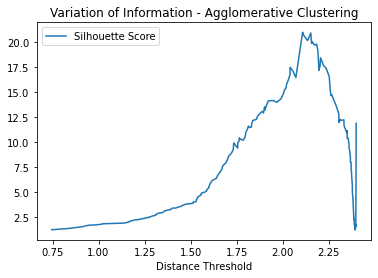

In [28]:
clust_dict = feature_clustering.get_optimal_clusters(varMatrix,'singlelink')

### MDA 

In [ ]:
model =RandomForestRegressor(criterion= 'mse',
                              max_depth= 23,
                              max_features= 55,
                              max_leaf_nodes= 400,
                              max_samples= 0.9,
                              min_samples_leaf= 39,
                              min_samples_split= 4,
                              n_estimators= 250,
                              n_jobs= -1,
                              random_state=42,
                              verbose= 0)

In [30]:
start_time = time.time()
MDA_values = feature_selection_numerai.mean_decrease_accuracy(model,train_x, train_y,train_era,6, client,workers, clust_dict)
runtime_2 = time.time()-start_time

0 0 10
0
0 0 10
5
0 0 10
10
8 0 2
15
10 0 0


Large object of size 8.93 MB detected in task graph: 
  (RandomForestRegressor(max_depth=14, max_features= ... 4d37e8a38c82c')
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good


Features sorted by their score:


In [31]:
feat_score = pd.DataFrame(scores, columns=["Score","Feature"])

feat_score.to_csv("MDA_Feature_Clustering_VarInfo_AggClust.csv",index = False)


### DR Tuning

In [32]:
feat_score = pd.read_csv('MDA_Feature_Clustering_VarInfo_AggClust.csv',)
feat_score

,Score,Feature
0,0.002800,[139 142]
1,0.002214,[141 146]
2,0.001346,[147 149]
3,0.000913,[138 143]
4,0.000725,[111 131]
...,...,...
123,-0.000203,[55 85]
124,-0.000244,[40 82]
125,-0.000246,[105 125]
126,-0.000283,[158 182 195 209 236 261]


In [66]:
model =RandomForestRegressor(criterion= 'mse',
                               random_state = 42,
                               n_estimators =500,
                               max_depth=43,
                               verbose = 0,
                               max_features= 'auto', 
                               n_jobs=-1,
                               max_leaf_nodes=660, 
                               min_samples_leaf = 7, 
                               min_samples_split = 12,
                               max_samples = .6)
MDA_tune = feature_selection_numerai.mean_decrease_accuracy_tune(model,train_x,train_y,train_era, MDA_values,6,192 ,client,workers,is_clustered=True)
MDA_tune

[139 142]
[139 142 141 146]
[139 142 141 146 147 149]
[139 142 141 146 147 149 138 143]
[139 142 141 146 147 149 138 143 111 131]
[139 142 141 146 147 149 138 143 111 131  74  96]
[139 142 141 146 147 149 138 143 111 131  74  96  20  80]
[139 142 141 146 147 149 138 143 111 131  74  96  20  80  29  48  87  92]
[139 142 141 146 147 149 138 143 111 131  74  96  20  80  29  48  87  92
 277 297 298]
[139 142 141 146 147 149 138 143 111 131  74  96  20  80  29  48  87  92
 277 297 298 100 116]
[139 142 141 146 147 149 138 143 111 131  74  96  20  80  29  48  87  92
 277 297 298 100 116 268 303 304 307]
[139 142 141 146 147 149 138 143 111 131  74  96  20  80  29  48  87  92
 277 297 298 100 116 268 303 304 307 286 295]
[139 142 141 146 147 149 138 143 111 131  74  96  20  80  29  48  87  92
 277 297 298 100 116 268 303 304 307 286 295 294 299 300 301 302 305]
[139 142 141 146 147 149 138 143 111 131  74  96  20  80  29  48  87  92
 277 297 298 100 116 268 303 304 307 286 295 294 299 300 301

,Spearman Rank,QME
56,0.050454,0.026403
66,0.050405,0.026403
60,0.050332,0.026403
69,0.050324,0.026403
76,0.050246,0.026403
...,...,...
4,0.017461,0.026550
0,0.014832,0.026486
1,0.013497,0.026531
3,0.012751,0.026557


In [70]:
MDA_train_x = feature_selection_numerai.mean_decrease_accuracy_selector(train_x,MDA_tune,1,is_clustered=True)
MDA_train_x.shape

0                                   [139, 142]
1                                   [141, 146]
2                                   [147, 149]
3                                   [138, 143]
4                                   [111, 131]
5                                     [74, 96]
6                                     [20, 80]
7                             [29, 48, 87, 92]
8                              [277, 297, 298]
9                                   [100, 116]
10                        [268, 303, 304, 307]
11                                  [286, 295]
12              [294, 299, 300, 301, 302, 305]
13                        [187, 216, 260, 263]
14                                    [12, 30]
15                                      [1, 2]
16                                    [32, 47]
17                        [154, 155, 159, 223]
18                        [205, 240, 251, 259]
19                        [267, 279, 293, 308]
20                        [136, 137, 144, 145]
21           

(501808, 148)

### Model Evaluation

In [73]:
params = [{
    
    "n_estimators": range(500,1501,250),
    "min_samples_split" : range(2,10, 2),
    "max_leaf_nodes" : range(400,751,20),
    #"oob_score" :[True],
    "max_depth": range(3,55,10),
    "min_samples_leaf":range(5,40,2),
    "max_samples": np.arange(5,10)*.1,
    "verbose" : [0], 
    "n_jobs" : [-1],
    "random_state" : [42],
    "max_features" : range(5,50,5),
    "criterion" : ['mse']
}]
model = RandomForestRegressor
hyp_param = tuners.hyperband(model,MDA_train_x,train_y,train_era, 6,params, 500,3,100,client)

Done Scattering

*** 81 configurations x 1.2 ratio
0 0 405
0
23 0 382
5
56 0 349
10
93 0 312
15
268 0 137
20
405 0 0

0 | current score: 0.01865029217277038 | best score so far: 0.0187 (parameters {'criterion': 'mse', 'max_depth': 43, 'max_features': 50, 'max_leaf_nodes': 540, 'max_samples': 0.7000000000000001, 'min_samples_leaf': 17, 'min_samples_split': 4, 'n_estimators': 1000, 'n_jobs': -1, 'random_state': 42, 'verbose': 0})


*** 27.0 configurations x 3.7 ratio
0 0 135
0
14 0 121
5
99 0 36
10
135 0 0

0 | current score: 0.034743969911175544 | best score so far: 0.0347 (parameters {'criterion': 'mse', 'max_depth': 23, 'max_features': 95, 'max_leaf_nodes': 480, 'max_samples': 0.7000000000000001, 'min_samples_leaf': 19, 'min_samples_split': 2, 'n_estimators': 1250, 'n_jobs': -1, 'random_state': 42, 'verbose': 0})


*** 9.0 configurations x 11.1 ratio
0 0 45
0
0 0 45
5
20 0 25
10
35 0 10
15
43 0 2
20
45 0 0

0 | current score: 0.04212429361157621 | best score so far: 0.0421 (parameters

In [74]:
hyp_param


(0.04957110193984347,
 {'criterion': 'mse',
  'max_depth': 43,
  'max_features': 20,
  'max_leaf_nodes': 600,
  'max_samples': 0.6000000000000001,
  'min_samples_leaf': 25,
  'min_samples_split': 2,
  'n_estimators': 1500,
  'n_jobs': -1,
  'random_state': 42,
  'verbose': 0})

In [75]:
model = RandomForestRegressor(criterion= 'mse',
                              max_depth= 13,
                              max_features= 10,
                              max_leaf_nodes= 400,
                              max_samples= 0.6,
                              min_samples_leaf= 29,
                              min_samples_split= 6,
                              n_estimators= 1000,
                              n_jobs= -1,
                              random_state= 42,
                              verbose = 0)

In [77]:
spearman, qme = tuners.kfold_dask(model,MDA_train_x, train_y, train_era,12,client)
redux_race = pd.DataFrame({"Reduction Technique": "Var. of Info. Hier - 148 Components", 'Spearman Rank Corr by ERA Mean':spearman[0],'S CI 2.5%': spearman[1][0],'S CI 97.5%':spearman[1][1],'Quartic Mean Error': qme[0],'Q CI 2.5%': qme[1][0],'Q CI 97.5%':qme[1][1],'Runtime':runtime_1+runtime_2+runtime_3},index=[0])
redux_race.to_csv('../numerai_reduction_race.csv',mode='a',header = False)

0 0 10
0
0 0 10
5
0 0 10
10
0 0 10
15
0 0 10
20
0 0 10
25
0 0 10
30
0 0 10
35
0 0 10
40
0 0 10
45
0 0 10
50
0 0 10
55
0 0 10
60
0 0 10
65
0 0 10
70
0 0 10
75
2 0 8
80
6 0 4
85
7 0 3
90
9 0 1
95
10 0 0


## K-Medoids

,Silhouette Score,Number of Clusters
0,9.200635,2
1,3.745468,3
2,0.913058,4
3,1.531253,5
4,0.102154,6
...,...,...
193,5.289720,195
194,5.100089,196
195,5.157725,197
196,5.094224,198


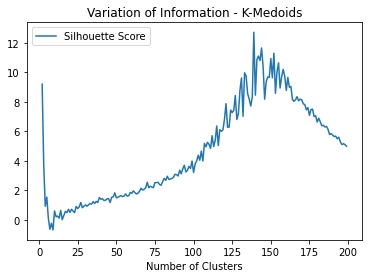

In [28]:
clust_dict = feature_clustering.get_optimal_clusters(varMatrix,'kmedoids')

### MDA

In [ ]:
model =RandomForestRegressor(criterion= 'mse',
                              max_depth= 23,
                              max_features= 55,
                              max_leaf_nodes= 400,
                              max_samples= 0.9,
                              min_samples_leaf= 39,
                              min_samples_split= 4,
                              n_estimators= 250,
                              n_jobs= -1,
                              random_state=42,
                              verbose= 0)

In [30]:
start_time = time.time()
MDA_values = feature_selection_numerai.mean_decrease_accuracy(model,train_x, train_y,train_era,6, client,workers, clust_dict)
runtime_2 = time.time()-start_time

0 0 10
0
0 0 10
5
0 0 10
10
8 0 2
15
10 0 0


Large object of size 8.93 MB detected in task graph: 
  (RandomForestRegressor(max_depth=14, max_features= ... 4d37e8a38c82c')
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good


Features sorted by their score:


In [31]:
feat_score =  pd.DataFrame(scores, columns=["Score","Feature"])

feat_score.to_csv("MDA_Feature_Clustering_VarInfo_kMedoids.csv",index=False)


### DR Tuning

In [32]:
feat_score = pd.read_csv('MDA_Feature_Clustering_VarInfo_kMedoids.csv')
feat_score

,Score,Feature
0,0.002863,[139 142]
1,0.002006,[141 146]
2,0.001369,[147 149]
3,0.001231,[138 143]
4,0.000828,[74 96]
...,...,...
134,-0.000169,[105 125]
135,-0.000174,[34 50]
136,-0.000181,[280 292]
137,-0.000231,[40 82]


In [ ]:

model =RandomForestRegressor(criterion= 'mse',
                              max_depth= 23,
                              max_features= 'auto',
                              max_leaf_nodes= 400,
                              max_samples= 0.9,
                              min_samples_leaf= 39,
                              min_samples_split= 4,
                              n_estimators= 250,
                              n_jobs= -1,
                              random_state=42,
                              verbose= 0)
MDA_tune = feature_selection_numerai.mean_decrease_accuracy_tune(model,train_x,train_y,train_era, MDA_values,6,192 ,client,workers,is_clustered=True)
MDA_tune

In [ ]:
MDA_train_x = feature_selection_numerai.mean_decrease_accuracy_selector(train_x,MDA_tune,16,is_clustered=True)
MDA_train_x.shape

### Model Evaluation

In [37]:
params = [{
    
    "n_estimators": range(500,1501,250),
    "min_samples_split" : range(2,10, 2),
    "max_leaf_nodes" : range(400,751,20),
    #"oob_score" :[True],
    "max_depth": range(3,55,10),
    "min_samples_leaf":range(5,40,2),
    "max_samples": np.arange(5,10)*.1,
    "verbose" : [0], 
    "n_jobs" : [-1],
    "random_state" : [42],
    "max_features" : range(5,50,5),
    "criterion" : ['mse']
}]
model = RandomForestRegressor
hyp_param = tuners.hyperband(model,MDA_train_x,train_y,train_era, 6,params, 500,3,100,client)

Done Scattering

*** 81 configurations x 1.2 ratio
0 0 405
0
31 0 374
5
66 0 339
10
95 0 310
15
282 0 123
20
405 0 0

0 | current score: 0.020007787728304076 | best score so far: 0.0200 (parameters {'criterion': 'mse', 'max_depth': 23, 'max_features': 145, 'max_leaf_nodes': 720, 'max_samples': 0.5, 'min_samples_leaf': 7, 'min_samples_split': 2, 'n_estimators': 1250, 'n_jobs': -1, 'random_state': 42, 'verbose': 0})


*** 27.0 configurations x 3.7 ratio
0 0 135
0
0 0 135
5
30 0 105
10
110 0 25
15
129 0 6
20
135 0 0

0 | current score: 0.03517706276755684 | best score so far: 0.0352 (parameters {'criterion': 'mse', 'max_depth': 13, 'max_features': 20, 'max_leaf_nodes': 740, 'max_samples': 0.6000000000000001, 'min_samples_leaf': 9, 'min_samples_split': 8, 'n_estimators': 1500, 'n_jobs': -1, 'random_state': 42, 'verbose': 0})


*** 9.0 configurations x 11.1 ratio
0 0 45
0
0 0 45
5
17 0 28
10
20 0 25
15
33 0 12
20
35 0 10
25
39 0 6
30
41 0 4
35
45 0 0

0 | current score: 0.041563610399438455

In [38]:
hyp_param


(0.049830982273759074,
 {'criterion': 'mse',
  'max_depth': 13,
  'max_features': 50,
  'max_leaf_nodes': 680,
  'max_samples': 0.5,
  'min_samples_leaf': 31,
  'min_samples_split': 2,
  'n_estimators': 1250,
  'n_jobs': -1,
  'random_state': 42,
  'verbose': 0})

In [39]:
model = RandomForestRegressor(criterion= 'mse',
                              max_depth= 13,
                              max_features= 10,
                              max_leaf_nodes= 400,
                              max_samples= 0.6,
                              min_samples_leaf= 29,
                              min_samples_split= 6,
                              n_estimators= 1000,
                              n_jobs= -1,
                              random_state= 42,
                              verbose = 0)

In [40]:
spearman, qme = tuners.kfold_dask(model,MDA_train_x, train_y, train_era,12,client)
redux_race = pd.DataFrame({"Reduction Technique": "Var. of Info. K-Medoids - 148 Components", 'Spearman Rank Corr by ERA Mean':spearman[0],'S CI 2.5%': spearman[1][0],'S CI 97.5%':spearman[1][1],'Quartic Mean Error': qme[0],'Q CI 2.5%': qme[1][0],'Q CI 97.5%':qme[1][1],'Runtime':runtime_1+runtime_2+runtime_3},index=[0])
redux_race.to_csv('../numerai_reduction_race.csv',mode='a',header = False)

0 0 10
0
0 0 10
5
0 0 10
10
0 0 10
15
0 0 10
20
0 0 10
25
0 0 10
30
0 0 10
35
0 0 10
40
0 0 10
45
0 0 10
50
0 0 10
55
0 0 10
60
0 0 10
65
0 0 10
70
0 0 10
75
0 0 10
80
0 0 10
85
0 0 10
90
0 0 10
95
0 0 10
100
0 0 10
105
0 0 10
110
0 0 10
115
0 0 10
120
0 0 10
125
0 0 10
130
0 0 10
135
0 0 10
140
0 0 10
145
0 0 10
150
2 0 8
155
5 0 5
160
9 0 1
165
10 0 0


## HDBSCAN Clustering

In [33]:
clust_dict = feature_clustering.get_optimal_clusters(varMatrix,'hdbscan')

ValueError: Min cluster size must be greater than one

### MDA

In [ ]:
model =RandomForestRegressor(criterion= 'mse',
                              max_depth= 23,
                              max_features= 55,
                              max_leaf_nodes= 400,
                              max_samples= 0.9,
                              min_samples_leaf= 39,
                              min_samples_split= 4,
                              n_estimators= 250,
                              n_jobs= -1,
                              random_state=42,
                              verbose= 0)

In [30]:
start_time = time.time()
MDA_values = feature_selection_numerai.mean_decrease_accuracy(model,train_x, train_y,train_era,6, client,workers, clust_dict)
runtime_2 = time.time()-start_time

0 0 10
0
0 0 10
5
0 0 10
10
8 0 2
15
10 0 0


Large object of size 8.93 MB detected in task graph: 
  (RandomForestRegressor(max_depth=14, max_features= ... 4d37e8a38c82c')
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good


Features sorted by their score:


In [55]:
feat_score = pd.DataFrame(scores, columns=["Score","Feature"])
feat_score.to_pickle("MDA_Feature_Clustering_VarInfo_dbscan.csv")


### DR Tuning

In [56]:
feat_score = pd.read_pickle('MDA_Feature_Clustering_VarInfo_dbscan.csv')
feat_score

,Score,Feature
0,0.045165,[ 0 1 2 3 4 5 6 7 8 9 10 ...
1,0.000497,[117 135 150 169 175 192 211 229 233 234]
2,0.000288,[153 183 184 198 254 258]


In [ ]:

model =RandomForestRegressor(criterion= 'mse',
                              max_depth= 23,
                              max_features= 'auto',
                              max_leaf_nodes= 400,
                              max_samples= 0.9,
                              min_samples_leaf= 39,
                              min_samples_split= 4,
                              n_estimators= 250,
                              n_jobs= -1,
                              random_state=42,
                              verbose= 0)
MDA_tune = feature_selection_numerai.mean_decrease_accuracy_tune(model,train_x,train_y,train_era, MDA_values,6,192 ,client,workers,is_clustered=True)
MDA_tune

In [ ]:
MDA_train_x = feature_selection_numerai.mean_decrease_accuracy_selector(train_x,MDA_tune,16,is_clustered=True)
MDA_train_x.shape

### Model Evaluation

In [61]:
params = [{
    
    "n_estimators": range(500,1501,250),
    "min_samples_split" : range(2,10, 2),
    "max_leaf_nodes" : range(400,751,20),
    #"oob_score" :[True],
    "max_depth": range(3,55,10),
    "min_samples_leaf":range(5,40,2),
    "max_samples": np.arange(5,10)*.1,
    "verbose" : [0], 
    "n_jobs" : [-1],
    "random_state" : [42],
    "max_features" : range(5,200,5),
    "criterion" : ['mse']
}]
model = RandomForestRegressor
hyp_param = tuners.hyperband(model,MDA_train_x,train_y,train_era, 6,params, 500,3,100,client)

Done Scattering

*** 81 configurations x 1.2 ratio
0 0 405
0
26 0 379
5
66 0 339
10
90 0 315
15
128 0 277
20
257 0 148
25
392 0 13
30
405 0 0

0 | current score: 0.018940097218412527 | best score so far: 0.0189 (parameters {'criterion': 'mse', 'max_depth': 33, 'max_features': 70, 'max_leaf_nodes': 720, 'max_samples': 0.9, 'min_samples_leaf': 17, 'min_samples_split': 8, 'n_estimators': 1250, 'n_jobs': -1, 'random_state': 42, 'verbose': 0})


*** 27.0 configurations x 3.7 ratio
0 0 135
0
0 0 135
5
14 0 121
10
53 0 82
15
104 0 31
20
135 0 0

0 | current score: 0.03298200364603597 | best score so far: 0.0330 (parameters {'criterion': 'mse', 'max_depth': 53, 'max_features': 60, 'max_leaf_nodes': 560, 'max_samples': 0.9, 'min_samples_leaf': 17, 'min_samples_split': 6, 'n_estimators': 1000, 'n_jobs': -1, 'random_state': 42, 'verbose': 0})


*** 9.0 configurations x 11.1 ratio
0 0 45
0
0 0 45
5
0 0 45
10
4 0 41
15
5 0 40
20
9 0 36
25
18 0 27
30
26 0 19
35
34 0 11
40
39 0 6
45
40 0 5
50
44 0 1


In [62]:
hyp_param


(0.04849642234486283,
 {'criterion': 'mse',
  'max_depth': 43,
  'max_features': 35,
  'max_leaf_nodes': 720,
  'max_samples': 0.5,
  'min_samples_leaf': 37,
  'min_samples_split': 2,
  'n_estimators': 1500,
  'n_jobs': -1,
  'random_state': 42,
  'verbose': 0})

In [39]:
model = RandomForestRegressor(criterion= 'mse',
                              max_depth= 13,
                              max_features= 10,
                              max_leaf_nodes= 400,
                              max_samples= 0.6,
                              min_samples_leaf= 29,
                              min_samples_split= 6,
                              n_estimators= 1000,
                              n_jobs= -1,
                              random_state= 42,
                              verbose = 0)

In [64]:
spearman, qme = tuners.kfold_dask(model,MDA_train_x, train_y, train_era,12,client)
redux_race = pd.DataFrame({"Reduction Technique": "Var. of Info. HDBSCAN - 304 Components", 'Spearman Rank Corr by ERA Mean':spearman[0],'S CI 2.5%': spearman[1][0],'S CI 97.5%':spearman[1][1],'Quartic Mean Error': qme[0],'Q CI 2.5%': qme[1][0],'Q CI 97.5%':qme[1][1],'Runtime':runtime_1+runtime_2+runtime_3},index=[0])
redux_race.to_csv('../numerai_reduction_race.csv',mode='a',header = False)

0 0 10
0
0 0 10
5
0 0 10
10
0 0 10
15
0 0 10
20
0 0 10
25
0 0 10
30
0 0 10
35
0 0 10
40
0 0 10
45
0 0 10
50
0 0 10
55
0 0 10
60
0 0 10
65
0 0 10
70
0 0 10
75
0 0 10
80
0 0 10
85
0 0 10
90
0 0 10
95
0 0 10
100
0 0 10
105
0 0 10
110
0 0 10
115
0 0 10
120
2 0 8
125
5 0 5
130
6 0 4
135
8 0 2
140
8 0 2
145
9 0 1
150
10 0 0


# Maximal Correlation

## Distance Matrix Calculation

In [14]:
start_time = time.time()
maxCorrMatrix = feature_clustering.pairwise(train_x.T, distance_func.max_corr,client,workers)
runtime_1 = time.time()-start_time
maxCorrMatrix 

array([3.1558104 , 3.16024267, 2.64510558, ..., 3.17555738, 3.11175879,
       2.80174794])

## Agglomerative Clustering

0.7458635253479144
0.8370187988601434
0.8924778733351793
0.9115245502744371
0.9274760909938216
0.934071119771102
0.9490772472167426
0.986981961151689
1.0155638986318216
1.0191156650451674
1.0203447093547342
1.1029875436008243
1.1335055353490768
1.147586659724798
1.1495725927199785
1.160415402107337
1.1615692155110717
1.1649697789654394
1.1687919355616199
1.1744725053458533
1.1811494172410426
1.183770774115792
1.1896133720239233
1.197757340699161
1.2031376923131125
1.2196158952618286
1.219865742798622
1.234170337476871
1.2353643346919916
1.246106760101124
1.254141596542715
1.260274592832614
1.2612878217356378
1.274251143903023
1.2754626816546448
1.28328898060913
1.286792323218446
1.288903317406949
1.2950640880136
1.304137319666459
1.3103628441824633
1.3104707409936855
1.3121181899971925
1.3126560292495344
1.3151106075422119
1.3174680861821986
1.326366122463912
1.3282375500696948
1.34335112274477
1.3502059084389468
1.351703153715547
1.3535112249104746
1.3551320080938716
1.357888095731429

<AxesSubplot:title={'center':'Variation of Information - Agglomerative Clustering'}, xlabel='Distance Threshold'>

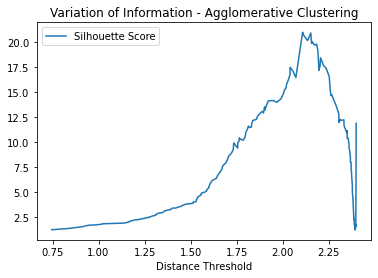

In [28]:
clust_dict = feature_clustering.get_optimal_clusters(maxCorrMatrix,'singlelink')

### MDA 

In [ ]:
model =RandomForestRegressor(criterion= 'mse',
                              max_depth= 23,
                              max_features= 55,
                              max_leaf_nodes= 400,
                              max_samples= 0.9,
                              min_samples_leaf= 39,
                              min_samples_split= 4,
                              n_estimators= 250,
                              n_jobs= -1,
                              random_state=42,
                              verbose= 0)

In [30]:
start_time = time.time()
MDA_values = feature_selection_numerai.mean_decrease_accuracy(model,train_x, train_y,train_era,6, client,workers, clust_dict)
runtime_2 = time.time()-start_time

0 0 10
0
0 0 10
5
0 0 10
10
8 0 2
15
10 0 0


Large object of size 8.93 MB detected in task graph: 
  (RandomForestRegressor(max_depth=14, max_features= ... 4d37e8a38c82c')
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good


Features sorted by their score:


In [31]:
feat_score = pd.DataFrame(scores, columns=["Score","Feature"])

feat_score.to_csv("MDA_Feature_Clustering_maxCorrMatrix_AggClust.csv",index = False)


### DR Tuning

In [32]:
feat_score = pd.read_csv('MDA_Feature_Clustering_maxCorrMatrix_AggClust.csv',)
feat_score

,Score,Feature
0,0.002800,[139 142]
1,0.002214,[141 146]
2,0.001346,[147 149]
3,0.000913,[138 143]
4,0.000725,[111 131]
...,...,...
123,-0.000203,[55 85]
124,-0.000244,[40 82]
125,-0.000246,[105 125]
126,-0.000283,[158 182 195 209 236 261]


In [66]:
model =RandomForestRegressor(criterion= 'mse',
                               random_state = 42,
                               n_estimators =500,
                               max_depth=43,
                               verbose = 0,
                               max_features= 'auto', 
                               n_jobs=-1,
                               max_leaf_nodes=660, 
                               min_samples_leaf = 7, 
                               min_samples_split = 12,
                               max_samples = .6)
MDA_tune = feature_selection_numerai.mean_decrease_accuracy_tune(model,train_x,train_y,train_era, MDA_values,6,192 ,client,workers,is_clustered=True)
MDA_tune

[139 142]
[139 142 141 146]
[139 142 141 146 147 149]
[139 142 141 146 147 149 138 143]
[139 142 141 146 147 149 138 143 111 131]
[139 142 141 146 147 149 138 143 111 131  74  96]
[139 142 141 146 147 149 138 143 111 131  74  96  20  80]
[139 142 141 146 147 149 138 143 111 131  74  96  20  80  29  48  87  92]
[139 142 141 146 147 149 138 143 111 131  74  96  20  80  29  48  87  92
 277 297 298]
[139 142 141 146 147 149 138 143 111 131  74  96  20  80  29  48  87  92
 277 297 298 100 116]
[139 142 141 146 147 149 138 143 111 131  74  96  20  80  29  48  87  92
 277 297 298 100 116 268 303 304 307]
[139 142 141 146 147 149 138 143 111 131  74  96  20  80  29  48  87  92
 277 297 298 100 116 268 303 304 307 286 295]
[139 142 141 146 147 149 138 143 111 131  74  96  20  80  29  48  87  92
 277 297 298 100 116 268 303 304 307 286 295 294 299 300 301 302 305]
[139 142 141 146 147 149 138 143 111 131  74  96  20  80  29  48  87  92
 277 297 298 100 116 268 303 304 307 286 295 294 299 300 301

,Spearman Rank,QME
56,0.050454,0.026403
66,0.050405,0.026403
60,0.050332,0.026403
69,0.050324,0.026403
76,0.050246,0.026403
...,...,...
4,0.017461,0.026550
0,0.014832,0.026486
1,0.013497,0.026531
3,0.012751,0.026557


In [70]:
MDA_train_x = feature_selection_numerai.mean_decrease_accuracy_selector(train_x,MDA_tune,1,is_clustered=True)
MDA_train_x.shape

0                                   [139, 142]
1                                   [141, 146]
2                                   [147, 149]
3                                   [138, 143]
4                                   [111, 131]
5                                     [74, 96]
6                                     [20, 80]
7                             [29, 48, 87, 92]
8                              [277, 297, 298]
9                                   [100, 116]
10                        [268, 303, 304, 307]
11                                  [286, 295]
12              [294, 299, 300, 301, 302, 305]
13                        [187, 216, 260, 263]
14                                    [12, 30]
15                                      [1, 2]
16                                    [32, 47]
17                        [154, 155, 159, 223]
18                        [205, 240, 251, 259]
19                        [267, 279, 293, 308]
20                        [136, 137, 144, 145]
21           

(501808, 148)

### Model Evaluation

In [73]:
params = [{
    
    "n_estimators": range(500,1501,250),
    "min_samples_split" : range(2,10, 2),
    "max_leaf_nodes" : range(400,751,20),
    #"oob_score" :[True],
    "max_depth": range(3,55,10),
    "min_samples_leaf":range(5,40,2),
    "max_samples": np.arange(5,10)*.1,
    "verbose" : [0], 
    "n_jobs" : [-1],
    "random_state" : [42],
    "max_features" : range(5,50,5),
    "criterion" : ['mse']
}]
model = RandomForestRegressor
hyp_param = tuners.hyperband(model,MDA_train_x,train_y,train_era, 6,params, 500,3,100,client)

Done Scattering

*** 81 configurations x 1.2 ratio
0 0 405
0
23 0 382
5
56 0 349
10
93 0 312
15
268 0 137
20
405 0 0

0 | current score: 0.01865029217277038 | best score so far: 0.0187 (parameters {'criterion': 'mse', 'max_depth': 43, 'max_features': 50, 'max_leaf_nodes': 540, 'max_samples': 0.7000000000000001, 'min_samples_leaf': 17, 'min_samples_split': 4, 'n_estimators': 1000, 'n_jobs': -1, 'random_state': 42, 'verbose': 0})


*** 27.0 configurations x 3.7 ratio
0 0 135
0
14 0 121
5
99 0 36
10
135 0 0

0 | current score: 0.034743969911175544 | best score so far: 0.0347 (parameters {'criterion': 'mse', 'max_depth': 23, 'max_features': 95, 'max_leaf_nodes': 480, 'max_samples': 0.7000000000000001, 'min_samples_leaf': 19, 'min_samples_split': 2, 'n_estimators': 1250, 'n_jobs': -1, 'random_state': 42, 'verbose': 0})


*** 9.0 configurations x 11.1 ratio
0 0 45
0
0 0 45
5
20 0 25
10
35 0 10
15
43 0 2
20
45 0 0

0 | current score: 0.04212429361157621 | best score so far: 0.0421 (parameters

In [74]:
hyp_param


(0.04957110193984347,
 {'criterion': 'mse',
  'max_depth': 43,
  'max_features': 20,
  'max_leaf_nodes': 600,
  'max_samples': 0.6000000000000001,
  'min_samples_leaf': 25,
  'min_samples_split': 2,
  'n_estimators': 1500,
  'n_jobs': -1,
  'random_state': 42,
  'verbose': 0})

In [75]:
model = RandomForestRegressor(criterion= 'mse',
                              max_depth= 13,
                              max_features= 10,
                              max_leaf_nodes= 400,
                              max_samples= 0.6,
                              min_samples_leaf= 29,
                              min_samples_split= 6,
                              n_estimators= 1000,
                              n_jobs= -1,
                              random_state= 42,
                              verbose = 0)

In [77]:
spearman, qme = tuners.kfold_dask(model,MDA_train_x, train_y, train_era,12,client)
redux_race = pd.DataFrame({"Reduction Technique": "Max. Corr Hier - 148 Components", 'Spearman Rank Corr by ERA Mean':spearman[0],'S CI 2.5%': spearman[1][0],'S CI 97.5%':spearman[1][1],'Quartic Mean Error': qme[0],'Q CI 2.5%': qme[1][0],'Q CI 97.5%':qme[1][1],'Runtime':runtime_1+runtime_2+runtime_3},index=[0])
redux_race.to_csv('../numerai_reduction_race.csv',mode='a',header = False)

0 0 10
0
0 0 10
5
0 0 10
10
0 0 10
15
0 0 10
20
0 0 10
25
0 0 10
30
0 0 10
35
0 0 10
40
0 0 10
45
0 0 10
50
0 0 10
55
0 0 10
60
0 0 10
65
0 0 10
70
0 0 10
75
2 0 8
80
6 0 4
85
7 0 3
90
9 0 1
95
10 0 0


## K-Medoids

,Silhouette Score,Number of Clusters
0,9.200635,2
1,3.745468,3
2,0.913058,4
3,1.531253,5
4,0.102154,6
...,...,...
193,5.289720,195
194,5.100089,196
195,5.157725,197
196,5.094224,198


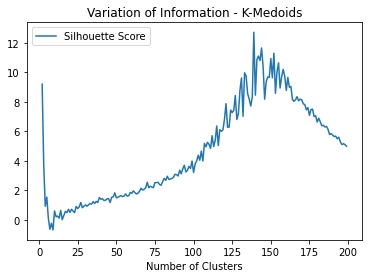

In [28]:
clust_dict = feature_clustering.get_optimal_clusters(maxCorrMatrix,'kmedoids')

### MDA

In [ ]:
model =RandomForestRegressor(criterion= 'mse',
                              max_depth= 23,
                              max_features= 55,
                              max_leaf_nodes= 400,
                              max_samples= 0.9,
                              min_samples_leaf= 39,
                              min_samples_split= 4,
                              n_estimators= 250,
                              n_jobs= -1,
                              random_state=42,
                              verbose= 0)

In [30]:
start_time = time.time()
MDA_values = feature_selection_numerai.mean_decrease_accuracy(model,train_x, train_y,train_era,6, client,workers, clust_dict)
runtime_2 = time.time()-start_time

0 0 10
0
0 0 10
5
0 0 10
10
8 0 2
15
10 0 0


Large object of size 8.93 MB detected in task graph: 
  (RandomForestRegressor(max_depth=14, max_features= ... 4d37e8a38c82c')
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good


Features sorted by their score:


In [31]:
feat_score =  pd.DataFrame(scores, columns=["Score","Feature"])

feat_score.to_csv("MDA_Feature_Clustering_maxCorrMatrix_kMedoids.csv",index=False)


### DR Tuning

In [32]:
feat_score = pd.read_csv('MDA_Feature_Clustering_maxCorrMatrix_kMedoids.csv')
feat_score

,Score,Feature
0,0.002863,[139 142]
1,0.002006,[141 146]
2,0.001369,[147 149]
3,0.001231,[138 143]
4,0.000828,[74 96]
...,...,...
134,-0.000169,[105 125]
135,-0.000174,[34 50]
136,-0.000181,[280 292]
137,-0.000231,[40 82]


In [ ]:

model =RandomForestRegressor(criterion= 'mse',
                              max_depth= 23,
                              max_features= 'auto',
                              max_leaf_nodes= 400,
                              max_samples= 0.9,
                              min_samples_leaf= 39,
                              min_samples_split= 4,
                              n_estimators= 250,
                              n_jobs= -1,
                              random_state=42,
                              verbose= 0)
MDA_tune = feature_selection_numerai.mean_decrease_accuracy_tune(model,train_x,train_y,train_era, MDA_values,6,192 ,client,workers,is_clustered=True)
MDA_tune

In [ ]:
MDA_train_x = feature_selection_numerai.mean_decrease_accuracy_selector(train_x,MDA_tune,16,is_clustered=True)
MDA_train_x.shape

### Model Evaluation

In [37]:
params = [{
    
    "n_estimators": range(500,1501,250),
    "min_samples_split" : range(2,10, 2),
    "max_leaf_nodes" : range(400,751,20),
    #"oob_score" :[True],
    "max_depth": range(3,55,10),
    "min_samples_leaf":range(5,40,2),
    "max_samples": np.arange(5,10)*.1,
    "verbose" : [0], 
    "n_jobs" : [-1],
    "random_state" : [42],
    "max_features" : range(5,50,5),
    "criterion" : ['mse']
}]
model = RandomForestRegressor
hyp_param = tuners.hyperband(model,MDA_train_x,train_y,train_era, 6,params, 500,3,100,client)

Done Scattering

*** 81 configurations x 1.2 ratio
0 0 405
0
31 0 374
5
66 0 339
10
95 0 310
15
282 0 123
20
405 0 0

0 | current score: 0.020007787728304076 | best score so far: 0.0200 (parameters {'criterion': 'mse', 'max_depth': 23, 'max_features': 145, 'max_leaf_nodes': 720, 'max_samples': 0.5, 'min_samples_leaf': 7, 'min_samples_split': 2, 'n_estimators': 1250, 'n_jobs': -1, 'random_state': 42, 'verbose': 0})


*** 27.0 configurations x 3.7 ratio
0 0 135
0
0 0 135
5
30 0 105
10
110 0 25
15
129 0 6
20
135 0 0

0 | current score: 0.03517706276755684 | best score so far: 0.0352 (parameters {'criterion': 'mse', 'max_depth': 13, 'max_features': 20, 'max_leaf_nodes': 740, 'max_samples': 0.6000000000000001, 'min_samples_leaf': 9, 'min_samples_split': 8, 'n_estimators': 1500, 'n_jobs': -1, 'random_state': 42, 'verbose': 0})


*** 9.0 configurations x 11.1 ratio
0 0 45
0
0 0 45
5
17 0 28
10
20 0 25
15
33 0 12
20
35 0 10
25
39 0 6
30
41 0 4
35
45 0 0

0 | current score: 0.041563610399438455

In [38]:
hyp_param


(0.049830982273759074,
 {'criterion': 'mse',
  'max_depth': 13,
  'max_features': 50,
  'max_leaf_nodes': 680,
  'max_samples': 0.5,
  'min_samples_leaf': 31,
  'min_samples_split': 2,
  'n_estimators': 1250,
  'n_jobs': -1,
  'random_state': 42,
  'verbose': 0})

In [39]:
model = RandomForestRegressor(criterion= 'mse',
                              max_depth= 13,
                              max_features= 10,
                              max_leaf_nodes= 400,
                              max_samples= 0.6,
                              min_samples_leaf= 29,
                              min_samples_split= 6,
                              n_estimators= 1000,
                              n_jobs= -1,
                              random_state= 42,
                              verbose = 0)

In [40]:
spearman, qme = tuners.kfold_dask(model,MDA_train_x, train_y, train_era,12,client)
redux_race = pd.DataFrame({"Reduction Technique": "Max. Corr. K-Medoids - 148 Components", 'Spearman Rank Corr by ERA Mean':spearman[0],'S CI 2.5%': spearman[1][0],'S CI 97.5%':spearman[1][1],'Quartic Mean Error': qme[0],'Q CI 2.5%': qme[1][0],'Q CI 97.5%':qme[1][1],'Runtime':runtime_1+runtime_2+runtime_3},index=[0])
redux_race.to_csv('../numerai_reduction_race.csv',mode='a',header = False)

0 0 10
0
0 0 10
5
0 0 10
10
0 0 10
15
0 0 10
20
0 0 10
25
0 0 10
30
0 0 10
35
0 0 10
40
0 0 10
45
0 0 10
50
0 0 10
55
0 0 10
60
0 0 10
65
0 0 10
70
0 0 10
75
0 0 10
80
0 0 10
85
0 0 10
90
0 0 10
95
0 0 10
100
0 0 10
105
0 0 10
110
0 0 10
115
0 0 10
120
0 0 10
125
0 0 10
130
0 0 10
135
0 0 10
140
0 0 10
145
0 0 10
150
2 0 8
155
5 0 5
160
9 0 1
165
10 0 0


## HDBSCAN Clustering

,Silhouette Score,Number of Clusters
0,9.200635,2
1,3.745468,3
2,0.913058,4
3,1.531253,5
4,0.102154,6
...,...,...
193,5.289720,195
194,5.100089,196
195,5.157725,197
196,5.094224,198


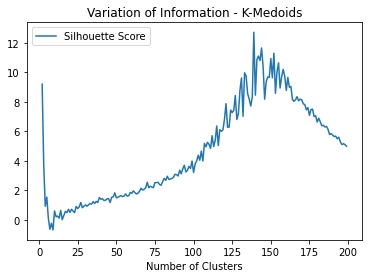

In [28]:
clust_dict = feature_clustering.get_optimal_clusters(maxCorrMatrix,'hdbscan')

### MDA

In [ ]:
model =RandomForestRegressor(criterion= 'mse',
                              max_depth= 23,
                              max_features= 55,
                              max_leaf_nodes= 400,
                              max_samples= 0.9,
                              min_samples_leaf= 39,
                              min_samples_split= 4,
                              n_estimators= 250,
                              n_jobs= -1,
                              random_state=42,
                              verbose= 0)

In [30]:
start_time = time.time()
MDA_values = feature_selection_numerai.mean_decrease_accuracy(model,train_x, train_y,train_era,6, client,workers, clust_dict)
runtime_2 = time.time()-start_time

0 0 10
0
0 0 10
5
0 0 10
10
8 0 2
15
10 0 0


Large object of size 8.93 MB detected in task graph: 
  (RandomForestRegressor(max_depth=14, max_features= ... 4d37e8a38c82c')
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good


Features sorted by their score:


In [31]:
feat_score =  pd.DataFrame(scores, columns=["Score","Feature"])

feat_score.to_csv("MDA_Feature_Clustering_maxCorrMatrix_HDBSCAN.csv",index=False)


### DR Tuning

In [32]:
feat_score = pd.read_csv('MDA_Feature_Clustering_maxCorrMatrix_HDBSCAN.csv')
feat_score

,Score,Feature
0,0.002863,[139 142]
1,0.002006,[141 146]
2,0.001369,[147 149]
3,0.001231,[138 143]
4,0.000828,[74 96]
...,...,...
134,-0.000169,[105 125]
135,-0.000174,[34 50]
136,-0.000181,[280 292]
137,-0.000231,[40 82]


In [ ]:

model =RandomForestRegressor(criterion= 'mse',
                              max_depth= 23,
                              max_features= 'auto',
                              max_leaf_nodes= 400,
                              max_samples= 0.9,
                              min_samples_leaf= 39,
                              min_samples_split= 4,
                              n_estimators= 250,
                              n_jobs= -1,
                              random_state=42,
                              verbose= 0)
MDA_tune = feature_selection_numerai.mean_decrease_accuracy_tune(model,train_x,train_y,train_era, MDA_values,6,192 ,client,workers,is_clustered=True)
MDA_tune

In [ ]:
MDA_train_x = feature_selection_numerai.mean_decrease_accuracy_selector(train_x,MDA_tune,16,is_clustered=True)
MDA_train_x.shape

### Model Evaluation

In [37]:
params = [{
    
    "n_estimators": range(500,1501,250),
    "min_samples_split" : range(2,10, 2),
    "max_leaf_nodes" : range(400,751,20),
    #"oob_score" :[True],
    "max_depth": range(3,55,10),
    "min_samples_leaf":range(5,40,2),
    "max_samples": np.arange(5,10)*.1,
    "verbose" : [0], 
    "n_jobs" : [-1],
    "random_state" : [42],
    "max_features" : range(5,50,5),
    "criterion" : ['mse']
}]
model = RandomForestRegressor
hyp_param = tuners.hyperband(model,MDA_train_x,train_y,train_era, 6,params, 500,3,100,client)

Done Scattering

*** 81 configurations x 1.2 ratio
0 0 405
0
31 0 374
5
66 0 339
10
95 0 310
15
282 0 123
20
405 0 0

0 | current score: 0.020007787728304076 | best score so far: 0.0200 (parameters {'criterion': 'mse', 'max_depth': 23, 'max_features': 145, 'max_leaf_nodes': 720, 'max_samples': 0.5, 'min_samples_leaf': 7, 'min_samples_split': 2, 'n_estimators': 1250, 'n_jobs': -1, 'random_state': 42, 'verbose': 0})


*** 27.0 configurations x 3.7 ratio
0 0 135
0
0 0 135
5
30 0 105
10
110 0 25
15
129 0 6
20
135 0 0

0 | current score: 0.03517706276755684 | best score so far: 0.0352 (parameters {'criterion': 'mse', 'max_depth': 13, 'max_features': 20, 'max_leaf_nodes': 740, 'max_samples': 0.6000000000000001, 'min_samples_leaf': 9, 'min_samples_split': 8, 'n_estimators': 1500, 'n_jobs': -1, 'random_state': 42, 'verbose': 0})


*** 9.0 configurations x 11.1 ratio
0 0 45
0
0 0 45
5
17 0 28
10
20 0 25
15
33 0 12
20
35 0 10
25
39 0 6
30
41 0 4
35
45 0 0

0 | current score: 0.041563610399438455

In [38]:
hyp_param


(0.049830982273759074,
 {'criterion': 'mse',
  'max_depth': 13,
  'max_features': 50,
  'max_leaf_nodes': 680,
  'max_samples': 0.5,
  'min_samples_leaf': 31,
  'min_samples_split': 2,
  'n_estimators': 1250,
  'n_jobs': -1,
  'random_state': 42,
  'verbose': 0})

In [39]:
model = RandomForestRegressor(criterion= 'mse',
                              max_depth= 13,
                              max_features= 10,
                              max_leaf_nodes= 400,
                              max_samples= 0.6,
                              min_samples_leaf= 29,
                              min_samples_split= 6,
                              n_estimators= 1000,
                              n_jobs= -1,
                              random_state= 42,
                              verbose = 0)

In [40]:
spearman, qme = tuners.kfold_dask(model,MDA_train_x, train_y, train_era,12,client)
redux_race = pd.DataFrame({"Reduction Technique": "Max. Corr.HDBSCAN - 148 Components", 'Spearman Rank Corr by ERA Mean':spearman[0],'S CI 2.5%': spearman[1][0],'S CI 97.5%':spearman[1][1],'Quartic Mean Error': qme[0],'Q CI 2.5%': qme[1][0],'Q CI 97.5%':qme[1][1],'Runtime':runtime_1+runtime_2+runtime_3},index=[0])
redux_race.to_csv('../numerai_reduction_race.csv',mode='a',header = False)

0 0 10
0
0 0 10
5
0 0 10
10
0 0 10
15
0 0 10
20
0 0 10
25
0 0 10
30
0 0 10
35
0 0 10
40
0 0 10
45
0 0 10
50
0 0 10
55
0 0 10
60
0 0 10
65
0 0 10
70
0 0 10
75
0 0 10
80
0 0 10
85
0 0 10
90
0 0 10
95
0 0 10
100
0 0 10
105
0 0 10
110
0 0 10
115
0 0 10
120
0 0 10
125
0 0 10
130
0 0 10
135
0 0 10
140
0 0 10
145
0 0 10
150
2 0 8
155
5 0 5
160
9 0 1
165
10 0 0


# Distance Correlation

## Distance Matrix Calculation

In [14]:
start_time = time.time()
distCorrMatrix = feature_clustering.pairwise(train_x.T, distance_func.dist_corr,client,workers)
runtime_1 = time.time()-start_time
maxCorrMatrix 

array([3.1558104 , 3.16024267, 2.64510558, ..., 3.17555738, 3.11175879,
       2.80174794])

## Agglomerative Clustering

0.7458635253479144
0.8370187988601434
0.8924778733351793
0.9115245502744371
0.9274760909938216
0.934071119771102
0.9490772472167426
0.986981961151689
1.0155638986318216
1.0191156650451674
1.0203447093547342
1.1029875436008243
1.1335055353490768
1.147586659724798
1.1495725927199785
1.160415402107337
1.1615692155110717
1.1649697789654394
1.1687919355616199
1.1744725053458533
1.1811494172410426
1.183770774115792
1.1896133720239233
1.197757340699161
1.2031376923131125
1.2196158952618286
1.219865742798622
1.234170337476871
1.2353643346919916
1.246106760101124
1.254141596542715
1.260274592832614
1.2612878217356378
1.274251143903023
1.2754626816546448
1.28328898060913
1.286792323218446
1.288903317406949
1.2950640880136
1.304137319666459
1.3103628441824633
1.3104707409936855
1.3121181899971925
1.3126560292495344
1.3151106075422119
1.3174680861821986
1.326366122463912
1.3282375500696948
1.34335112274477
1.3502059084389468
1.351703153715547
1.3535112249104746
1.3551320080938716
1.357888095731429

<AxesSubplot:title={'center':'Variation of Information - Agglomerative Clustering'}, xlabel='Distance Threshold'>

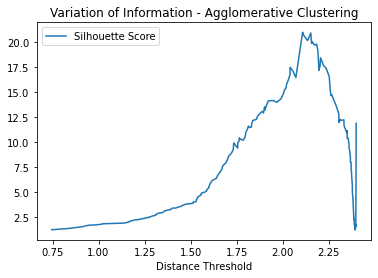

In [28]:
clust_dict = feature_clustering.get_optimal_clusters(distCorrMatrix,'singlelink')

### MDA 

In [ ]:
model =RandomForestRegressor(criterion= 'mse',
                              max_depth= 23,
                              max_features= 55,
                              max_leaf_nodes= 400,
                              max_samples= 0.9,
                              min_samples_leaf= 39,
                              min_samples_split= 4,
                              n_estimators= 250,
                              n_jobs= -1,
                              random_state=42,
                              verbose= 0)

In [30]:
start_time = time.time()
MDA_values = feature_selection_numerai.mean_decrease_accuracy(model,train_x, train_y,train_era,6, client,workers, clust_dict)
runtime_2 = time.time()-start_time

0 0 10
0
0 0 10
5
0 0 10
10
8 0 2
15
10 0 0


Large object of size 8.93 MB detected in task graph: 
  (RandomForestRegressor(max_depth=14, max_features= ... 4d37e8a38c82c')
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good


Features sorted by their score:


In [31]:
feat_score = pd.DataFrame(scores, columns=["Score","Feature"])

feat_score.to_csv("MDA_Feature_Clustering_distCorrMatrix_AggClust.csv",index = False)


### DR Tuning

In [32]:
feat_score = pd.read_csv('MDA_Feature_Clustering_distCorrMatrix_AggClust.csv',)
feat_score

,Score,Feature
0,0.002800,[139 142]
1,0.002214,[141 146]
2,0.001346,[147 149]
3,0.000913,[138 143]
4,0.000725,[111 131]
...,...,...
123,-0.000203,[55 85]
124,-0.000244,[40 82]
125,-0.000246,[105 125]
126,-0.000283,[158 182 195 209 236 261]


In [66]:
model =RandomForestRegressor(criterion= 'mse',
                               random_state = 42,
                               n_estimators =500,
                               max_depth=43,
                               verbose = 0,
                               max_features= 'auto', 
                               n_jobs=-1,
                               max_leaf_nodes=660, 
                               min_samples_leaf = 7, 
                               min_samples_split = 12,
                               max_samples = .6)
MDA_tune = feature_selection_numerai.mean_decrease_accuracy_tune(model,train_x,train_y,train_era, MDA_values,6,192 ,client,workers,is_clustered=True)
MDA_tune

[139 142]
[139 142 141 146]
[139 142 141 146 147 149]
[139 142 141 146 147 149 138 143]
[139 142 141 146 147 149 138 143 111 131]
[139 142 141 146 147 149 138 143 111 131  74  96]
[139 142 141 146 147 149 138 143 111 131  74  96  20  80]
[139 142 141 146 147 149 138 143 111 131  74  96  20  80  29  48  87  92]
[139 142 141 146 147 149 138 143 111 131  74  96  20  80  29  48  87  92
 277 297 298]
[139 142 141 146 147 149 138 143 111 131  74  96  20  80  29  48  87  92
 277 297 298 100 116]
[139 142 141 146 147 149 138 143 111 131  74  96  20  80  29  48  87  92
 277 297 298 100 116 268 303 304 307]
[139 142 141 146 147 149 138 143 111 131  74  96  20  80  29  48  87  92
 277 297 298 100 116 268 303 304 307 286 295]
[139 142 141 146 147 149 138 143 111 131  74  96  20  80  29  48  87  92
 277 297 298 100 116 268 303 304 307 286 295 294 299 300 301 302 305]
[139 142 141 146 147 149 138 143 111 131  74  96  20  80  29  48  87  92
 277 297 298 100 116 268 303 304 307 286 295 294 299 300 301

,Spearman Rank,QME
56,0.050454,0.026403
66,0.050405,0.026403
60,0.050332,0.026403
69,0.050324,0.026403
76,0.050246,0.026403
...,...,...
4,0.017461,0.026550
0,0.014832,0.026486
1,0.013497,0.026531
3,0.012751,0.026557


In [70]:
MDA_train_x = feature_selection_numerai.mean_decrease_accuracy_selector(train_x,MDA_tune,1,is_clustered=True)
MDA_train_x.shape

0                                   [139, 142]
1                                   [141, 146]
2                                   [147, 149]
3                                   [138, 143]
4                                   [111, 131]
5                                     [74, 96]
6                                     [20, 80]
7                             [29, 48, 87, 92]
8                              [277, 297, 298]
9                                   [100, 116]
10                        [268, 303, 304, 307]
11                                  [286, 295]
12              [294, 299, 300, 301, 302, 305]
13                        [187, 216, 260, 263]
14                                    [12, 30]
15                                      [1, 2]
16                                    [32, 47]
17                        [154, 155, 159, 223]
18                        [205, 240, 251, 259]
19                        [267, 279, 293, 308]
20                        [136, 137, 144, 145]
21           

(501808, 148)

### Model Evaluation

In [73]:
params = [{
    
    "n_estimators": range(500,1501,250),
    "min_samples_split" : range(2,10, 2),
    "max_leaf_nodes" : range(400,751,20),
    #"oob_score" :[True],
    "max_depth": range(3,55,10),
    "min_samples_leaf":range(5,40,2),
    "max_samples": np.arange(5,10)*.1,
    "verbose" : [0], 
    "n_jobs" : [-1],
    "random_state" : [42],
    "max_features" : range(5,50,5),
    "criterion" : ['mse']
}]
model = RandomForestRegressor
hyp_param = tuners.hyperband(model,MDA_train_x,train_y,train_era, 6,params, 500,3,100,client)

Done Scattering

*** 81 configurations x 1.2 ratio
0 0 405
0
23 0 382
5
56 0 349
10
93 0 312
15
268 0 137
20
405 0 0

0 | current score: 0.01865029217277038 | best score so far: 0.0187 (parameters {'criterion': 'mse', 'max_depth': 43, 'max_features': 50, 'max_leaf_nodes': 540, 'max_samples': 0.7000000000000001, 'min_samples_leaf': 17, 'min_samples_split': 4, 'n_estimators': 1000, 'n_jobs': -1, 'random_state': 42, 'verbose': 0})


*** 27.0 configurations x 3.7 ratio
0 0 135
0
14 0 121
5
99 0 36
10
135 0 0

0 | current score: 0.034743969911175544 | best score so far: 0.0347 (parameters {'criterion': 'mse', 'max_depth': 23, 'max_features': 95, 'max_leaf_nodes': 480, 'max_samples': 0.7000000000000001, 'min_samples_leaf': 19, 'min_samples_split': 2, 'n_estimators': 1250, 'n_jobs': -1, 'random_state': 42, 'verbose': 0})


*** 9.0 configurations x 11.1 ratio
0 0 45
0
0 0 45
5
20 0 25
10
35 0 10
15
43 0 2
20
45 0 0

0 | current score: 0.04212429361157621 | best score so far: 0.0421 (parameters

In [74]:
hyp_param


(0.04957110193984347,
 {'criterion': 'mse',
  'max_depth': 43,
  'max_features': 20,
  'max_leaf_nodes': 600,
  'max_samples': 0.6000000000000001,
  'min_samples_leaf': 25,
  'min_samples_split': 2,
  'n_estimators': 1500,
  'n_jobs': -1,
  'random_state': 42,
  'verbose': 0})

In [75]:
model = RandomForestRegressor(criterion= 'mse',
                              max_depth= 13,
                              max_features= 10,
                              max_leaf_nodes= 400,
                              max_samples= 0.6,
                              min_samples_leaf= 29,
                              min_samples_split= 6,
                              n_estimators= 1000,
                              n_jobs= -1,
                              random_state= 42,
                              verbose = 0)

In [77]:
spearman, qme = tuners.kfold_dask(model,MDA_train_x, train_y, train_era,12,client)
redux_race = pd.DataFrame({"Reduction Technique": "Dist. Corr Hier - 148 Components", 'Spearman Rank Corr by ERA Mean':spearman[0],'S CI 2.5%': spearman[1][0],'S CI 97.5%':spearman[1][1],'Quartic Mean Error': qme[0],'Q CI 2.5%': qme[1][0],'Q CI 97.5%':qme[1][1],'Runtime':runtime_1+runtime_2+runtime_3},index=[0])
redux_race.to_csv('../numerai_reduction_race.csv',mode='a',header = False)

0 0 10
0
0 0 10
5
0 0 10
10
0 0 10
15
0 0 10
20
0 0 10
25
0 0 10
30
0 0 10
35
0 0 10
40
0 0 10
45
0 0 10
50
0 0 10
55
0 0 10
60
0 0 10
65
0 0 10
70
0 0 10
75
2 0 8
80
6 0 4
85
7 0 3
90
9 0 1
95
10 0 0


## K-Medoids

,Silhouette Score,Number of Clusters
0,9.200635,2
1,3.745468,3
2,0.913058,4
3,1.531253,5
4,0.102154,6
...,...,...
193,5.289720,195
194,5.100089,196
195,5.157725,197
196,5.094224,198


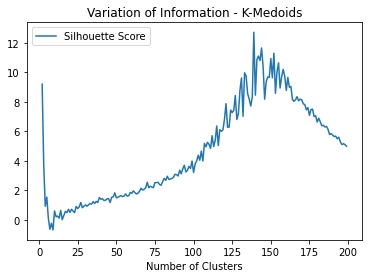

In [28]:
clust_dict = feature_clustering.get_optimal_clusters(distCorrMatrix,'kmedoids')

### MDA

In [ ]:
model =RandomForestRegressor(criterion= 'mse',
                              max_depth= 23,
                              max_features= 55,
                              max_leaf_nodes= 400,
                              max_samples= 0.9,
                              min_samples_leaf= 39,
                              min_samples_split= 4,
                              n_estimators= 250,
                              n_jobs= -1,
                              random_state=42,
                              verbose= 0)

In [30]:
start_time = time.time()
MDA_values = feature_selection_numerai.mean_decrease_accuracy(model,train_x, train_y,train_era,6, client,workers, clust_dict)
runtime_2 = time.time()-start_time

0 0 10
0
0 0 10
5
0 0 10
10
8 0 2
15
10 0 0


Large object of size 8.93 MB detected in task graph: 
  (RandomForestRegressor(max_depth=14, max_features= ... 4d37e8a38c82c')
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good


Features sorted by their score:


In [31]:
feat_score =  pd.DataFrame(scores, columns=["Score","Feature"])

feat_score.to_csv("MDA_Feature_Clustering_distCorrMatrix_kMedoids.csv",index=False)


### DR Tuning

In [32]:
feat_score = pd.read_csv('MDA_Feature_Clustering_distCorrMatrix_kMedoids.csv')
feat_score

,Score,Feature
0,0.002863,[139 142]
1,0.002006,[141 146]
2,0.001369,[147 149]
3,0.001231,[138 143]
4,0.000828,[74 96]
...,...,...
134,-0.000169,[105 125]
135,-0.000174,[34 50]
136,-0.000181,[280 292]
137,-0.000231,[40 82]


In [ ]:

model =RandomForestRegressor(criterion= 'mse',
                              max_depth= 23,
                              max_features= 'auto',
                              max_leaf_nodes= 400,
                              max_samples= 0.9,
                              min_samples_leaf= 39,
                              min_samples_split= 4,
                              n_estimators= 250,
                              n_jobs= -1,
                              random_state=42,
                              verbose= 0)
MDA_tune = feature_selection_numerai.mean_decrease_accuracy_tune(model,train_x,train_y,train_era, MDA_values,6,192 ,client,workers,is_clustered=True)
MDA_tune

In [ ]:
MDA_train_x = feature_selection_numerai.mean_decrease_accuracy_selector(train_x,MDA_tune,16,is_clustered=True)
MDA_train_x.shape

### Model Evaluation

In [37]:
params = [{
    
    "n_estimators": range(500,1501,250),
    "min_samples_split" : range(2,10, 2),
    "max_leaf_nodes" : range(400,751,20),
    #"oob_score" :[True],
    "max_depth": range(3,55,10),
    "min_samples_leaf":range(5,40,2),
    "max_samples": np.arange(5,10)*.1,
    "verbose" : [0], 
    "n_jobs" : [-1],
    "random_state" : [42],
    "max_features" : range(5,50,5),
    "criterion" : ['mse']
}]
model = RandomForestRegressor
hyp_param = tuners.hyperband(model,MDA_train_x,train_y,train_era, 6,params, 500,3,100,client)

Done Scattering

*** 81 configurations x 1.2 ratio
0 0 405
0
31 0 374
5
66 0 339
10
95 0 310
15
282 0 123
20
405 0 0

0 | current score: 0.020007787728304076 | best score so far: 0.0200 (parameters {'criterion': 'mse', 'max_depth': 23, 'max_features': 145, 'max_leaf_nodes': 720, 'max_samples': 0.5, 'min_samples_leaf': 7, 'min_samples_split': 2, 'n_estimators': 1250, 'n_jobs': -1, 'random_state': 42, 'verbose': 0})


*** 27.0 configurations x 3.7 ratio
0 0 135
0
0 0 135
5
30 0 105
10
110 0 25
15
129 0 6
20
135 0 0

0 | current score: 0.03517706276755684 | best score so far: 0.0352 (parameters {'criterion': 'mse', 'max_depth': 13, 'max_features': 20, 'max_leaf_nodes': 740, 'max_samples': 0.6000000000000001, 'min_samples_leaf': 9, 'min_samples_split': 8, 'n_estimators': 1500, 'n_jobs': -1, 'random_state': 42, 'verbose': 0})


*** 9.0 configurations x 11.1 ratio
0 0 45
0
0 0 45
5
17 0 28
10
20 0 25
15
33 0 12
20
35 0 10
25
39 0 6
30
41 0 4
35
45 0 0

0 | current score: 0.041563610399438455

In [38]:
hyp_param


(0.049830982273759074,
 {'criterion': 'mse',
  'max_depth': 13,
  'max_features': 50,
  'max_leaf_nodes': 680,
  'max_samples': 0.5,
  'min_samples_leaf': 31,
  'min_samples_split': 2,
  'n_estimators': 1250,
  'n_jobs': -1,
  'random_state': 42,
  'verbose': 0})

In [39]:
model = RandomForestRegressor(criterion= 'mse',
                              max_depth= 13,
                              max_features= 10,
                              max_leaf_nodes= 400,
                              max_samples= 0.6,
                              min_samples_leaf= 29,
                              min_samples_split= 6,
                              n_estimators= 1000,
                              n_jobs= -1,
                              random_state= 42,
                              verbose = 0)

In [40]:
spearman, qme = tuners.kfold_dask(model,MDA_train_x, train_y, train_era,12,client)
redux_race = pd.DataFrame({"Reduction Technique": "Dist. Corr. K-Medoids - 148 Components", 'Spearman Rank Corr by ERA Mean':spearman[0],'S CI 2.5%': spearman[1][0],'S CI 97.5%':spearman[1][1],'Quartic Mean Error': qme[0],'Q CI 2.5%': qme[1][0],'Q CI 97.5%':qme[1][1],'Runtime':runtime_1+runtime_2+runtime_3},index=[0])
redux_race.to_csv('../numerai_reduction_race.csv',mode='a',header = False)

0 0 10
0
0 0 10
5
0 0 10
10
0 0 10
15
0 0 10
20
0 0 10
25
0 0 10
30
0 0 10
35
0 0 10
40
0 0 10
45
0 0 10
50
0 0 10
55
0 0 10
60
0 0 10
65
0 0 10
70
0 0 10
75
0 0 10
80
0 0 10
85
0 0 10
90
0 0 10
95
0 0 10
100
0 0 10
105
0 0 10
110
0 0 10
115
0 0 10
120
0 0 10
125
0 0 10
130
0 0 10
135
0 0 10
140
0 0 10
145
0 0 10
150
2 0 8
155
5 0 5
160
9 0 1
165
10 0 0


## HDBSCAN Clustering

,Silhouette Score,Number of Clusters
0,9.200635,2
1,3.745468,3
2,0.913058,4
3,1.531253,5
4,0.102154,6
...,...,...
193,5.289720,195
194,5.100089,196
195,5.157725,197
196,5.094224,198


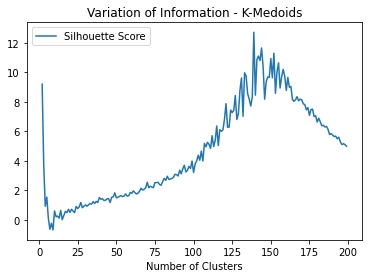

In [28]:
clust_dict = feature_clustering.get_optimal_clusters(distCorrMatrix,'hdbscan')

### MDA

In [ ]:
model =RandomForestRegressor(criterion= 'mse',
                              max_depth= 23,
                              max_features= 55,
                              max_leaf_nodes= 400,
                              max_samples= 0.9,
                              min_samples_leaf= 39,
                              min_samples_split= 4,
                              n_estimators= 250,
                              n_jobs= -1,
                              random_state=42,
                              verbose= 0)

In [30]:
start_time = time.time()
MDA_values = feature_selection_numerai.mean_decrease_accuracy(model,train_x, train_y,train_era,6, client,workers, clust_dict)
runtime_2 = time.time()-start_time

0 0 10
0
0 0 10
5
0 0 10
10
8 0 2
15
10 0 0


Large object of size 8.93 MB detected in task graph: 
  (RandomForestRegressor(max_depth=14, max_features= ... 4d37e8a38c82c')
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good


Features sorted by their score:


In [31]:
feat_score =  pd.DataFrame(scores, columns=["Score","Feature"])

feat_score.to_csv("MDA_Feature_Clustering_distCorrMatrix_HDBSCAN.csv",index=False)


### DR Tuning

In [32]:
feat_score = pd.read_csv('MDA_Feature_Clustering_distCorrMatrix_HDBSCAN.csv')
feat_score

,Score,Feature
0,0.002863,[139 142]
1,0.002006,[141 146]
2,0.001369,[147 149]
3,0.001231,[138 143]
4,0.000828,[74 96]
...,...,...
134,-0.000169,[105 125]
135,-0.000174,[34 50]
136,-0.000181,[280 292]
137,-0.000231,[40 82]


In [ ]:

model =RandomForestRegressor(criterion= 'mse',
                              max_depth= 23,
                              max_features= 'auto',
                              max_leaf_nodes= 400,
                              max_samples= 0.9,
                              min_samples_leaf= 39,
                              min_samples_split= 4,
                              n_estimators= 250,
                              n_jobs= -1,
                              random_state=42,
                              verbose= 0)
MDA_tune = feature_selection_numerai.mean_decrease_accuracy_tune(model,train_x,train_y,train_era, MDA_values,6,192 ,client,workers,is_clustered=True)
MDA_tune

In [ ]:
MDA_train_x = feature_selection_numerai.mean_decrease_accuracy_selector(train_x,MDA_tune,16,is_clustered=True)
MDA_train_x.shape

### Model Evaluation

In [37]:
params = [{
    
    "n_estimators": range(500,1501,250),
    "min_samples_split" : range(2,10, 2),
    "max_leaf_nodes" : range(400,751,20),
    #"oob_score" :[True],
    "max_depth": range(3,55,10),
    "min_samples_leaf":range(5,40,2),
    "max_samples": np.arange(5,10)*.1,
    "verbose" : [0], 
    "n_jobs" : [-1],
    "random_state" : [42],
    "max_features" : range(5,50,5),
    "criterion" : ['mse']
}]
model = RandomForestRegressor
hyp_param = tuners.hyperband(model,MDA_train_x,train_y,train_era, 6,params, 500,3,100,client)

Done Scattering

*** 81 configurations x 1.2 ratio
0 0 405
0
31 0 374
5
66 0 339
10
95 0 310
15
282 0 123
20
405 0 0

0 | current score: 0.020007787728304076 | best score so far: 0.0200 (parameters {'criterion': 'mse', 'max_depth': 23, 'max_features': 145, 'max_leaf_nodes': 720, 'max_samples': 0.5, 'min_samples_leaf': 7, 'min_samples_split': 2, 'n_estimators': 1250, 'n_jobs': -1, 'random_state': 42, 'verbose': 0})


*** 27.0 configurations x 3.7 ratio
0 0 135
0
0 0 135
5
30 0 105
10
110 0 25
15
129 0 6
20
135 0 0

0 | current score: 0.03517706276755684 | best score so far: 0.0352 (parameters {'criterion': 'mse', 'max_depth': 13, 'max_features': 20, 'max_leaf_nodes': 740, 'max_samples': 0.6000000000000001, 'min_samples_leaf': 9, 'min_samples_split': 8, 'n_estimators': 1500, 'n_jobs': -1, 'random_state': 42, 'verbose': 0})


*** 9.0 configurations x 11.1 ratio
0 0 45
0
0 0 45
5
17 0 28
10
20 0 25
15
33 0 12
20
35 0 10
25
39 0 6
30
41 0 4
35
45 0 0

0 | current score: 0.041563610399438455

In [38]:
hyp_param


(0.049830982273759074,
 {'criterion': 'mse',
  'max_depth': 13,
  'max_features': 50,
  'max_leaf_nodes': 680,
  'max_samples': 0.5,
  'min_samples_leaf': 31,
  'min_samples_split': 2,
  'n_estimators': 1250,
  'n_jobs': -1,
  'random_state': 42,
  'verbose': 0})

In [39]:
model = RandomForestRegressor(criterion= 'mse',
                              max_depth= 13,
                              max_features= 10,
                              max_leaf_nodes= 400,
                              max_samples= 0.6,
                              min_samples_leaf= 29,
                              min_samples_split= 6,
                              n_estimators= 1000,
                              n_jobs= -1,
                              random_state= 42,
                              verbose = 0)

In [40]:
spearman, qme = tuners.kfold_dask(model,MDA_train_x, train_y, train_era,12,client)
redux_race = pd.DataFrame({"Reduction Technique": "Dist. Corr. HDBSCAN - 148 Components", 'Spearman Rank Corr by ERA Mean':spearman[0],'S CI 2.5%': spearman[1][0],'S CI 97.5%':spearman[1][1],'Quartic Mean Error': qme[0],'Q CI 2.5%': qme[1][0],'Q CI 97.5%':qme[1][1],'Runtime':runtime_1+runtime_2+runtime_3},index=[0])
redux_race.to_csv('../numerai_reduction_race.csv',mode='a',header = False)

0 0 10
0
0 0 10
5
0 0 10
10
0 0 10
15
0 0 10
20
0 0 10
25
0 0 10
30
0 0 10
35
0 0 10
40
0 0 10
45
0 0 10
50
0 0 10
55
0 0 10
60
0 0 10
65
0 0 10
70
0 0 10
75
0 0 10
80
0 0 10
85
0 0 10
90
0 0 10
95
0 0 10
100
0 0 10
105
0 0 10
110
0 0 10
115
0 0 10
120
0 0 10
125
0 0 10
130
0 0 10
135
0 0 10
140
0 0 10
145
0 0 10
150
2 0 8
155
5 0 5
160
9 0 1
165
10 0 0
